# Assignment 3: LSTM and GRU vs. Multiplicative Variations

### Maxim Ryabinov (U02204083)
### CAP4641: Natural Language Processing 
### Instructor: Dr. Ankur Mali 
### University of South Florida (Spring 2025)

---

# Description

In this assignment, I implemented Standard LSTM RNN, Standard GRU RNN, Multiplicative LSTM RNN, and Multiplicative GRU RNN. My choice for the machine learning library used in this notebook is TensorFlow.

Below, you will find an implementation for each recurrent neural network architecture, all following a set of model equations that each of the architectures are based off of.

Lastly, in order to show robustness and highlight the differences in gating mechanisms between the architectures, the Copy Task is carried out. Each model is ran through this task using varying lengths of sequences that contain a randomly generated set of characters (sequences lengths: `{100, 200, 500, 1000}`).



---

# 1. Initial Setup

In [11]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import time
import os
import random

# Set seeds for reproducibility
seed = 123

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# # Make TensorFlow deterministic
# os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Force TensorFlow to use deterministic ops
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Ensure cuDNN is deterministic

# 2. Defining each RNN Architecture

### Standard LSTM RNN Implementation

In [12]:
class StandardLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate weights
        self.W_i = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_i = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Forget gate weights
        self.W_f = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_f = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Output gate weights
        self.W_o = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_o = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Cell candidate weights
        self.W_c = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_c = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev, c_prev):
        i_t = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f_t = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o_t = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        
        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * tf.tanh(c_t)
        
        return h_t, c_t

# ------- Higher-level TF RNN that unrolls over time -------
class StandardLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = StandardLSTMCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state = None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
            c = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h, c = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), (h, c)  # [batch_size, seq_length, input_size] and h, c

### Multiplicative LSTM RNN Implementation

In [13]:
class MultiplicativeLSTMCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate weights and bias
        self.W_i = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_i = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_i = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Forget gate weights and bias
        self.W_f = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_f = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_f = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Output gate weights and bias
        self.W_o = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_o = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_o = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Cell candidate weights and bias
        self.W_c = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_c = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_c = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

        # Multiplicative extension weights and bias
        self.W_m = self.add_weight(shape=(input_size, input_size), initializer="random_normal", trainable=True)
        self.U_m = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_m = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev, c_prev):
        # Multiplicative Extension
        m_t = tf.matmul(x_t, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_cap = m_t * x_t

        i_t = tf.sigmoid(tf.matmul(x_cap, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f_t = tf.sigmoid(tf.matmul(x_cap, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        o_t = tf.sigmoid(tf.matmul(x_cap, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        c_hat = tf.tanh(tf.matmul(x_cap, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        
        c_t = f_t * c_prev + i_t * c_hat
        h_t = o_t * tf.tanh(c_t)
        
        return h_t, c_t

class MultiplicativeLSTM(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = MultiplicativeLSTMCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]

        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
            c = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h, c = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h, c = self.lstm_cell(x_t, h, c)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), (h, c)  # [batch_size, seq_length, input_size] and h, c

### Standard GRU RNN Implementation

In [14]:
class StandardGRUCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Update gate weights
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_z = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Reset gate weights
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_r = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Candidate hidden state weights
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_h = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev):
        # Update gate
        z_t = tf.sigmoid(tf.matmul(x_t, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        
        # Reset gate
        r_t = tf.sigmoid(tf.matmul(x_t, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        
        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(x_t, self.W_h) + tf.matmul(r_t * h_prev, self.U_h) + self.b_h)
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_hat
        
        return h_t

# ------- Higher-level TF RNN that unrolls over time -------
class StandardGRU(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = StandardGRUCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), h  # [batch_size, seq_length, input_size] and h

### Multiplicative GRU RNN Implementation

In [15]:
class MultiplicativeGRUCell(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Update gate weights
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_z = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Reset gate weights
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_r = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)
        
        # Candidate hidden state weights
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer="random_normal", trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True)
        self.b_h = self.add_weight(shape=(hidden_size,), initializer="zeros", trainable=True)

        # Multiplicative extension weights and bias
        self.W_m = self.add_weight(shape=(input_size, input_size), initializer="random_normal", trainable=True)
        self.U_m = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_m = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, x_t, h_prev):
        # Memory matrix introduction
        m_t = tf.matmul(x_t, self.W_m) + tf.matmul(h_prev, self.U_m) + self.b_m
        x_cap = m_t * x_t

        # Update gate
        z_t = tf.sigmoid(tf.matmul(x_cap, self.W_z) + tf.matmul(h_prev, self.U_z) + self.b_z)
        
        # Reset gate
        r_t = tf.sigmoid(tf.matmul(x_cap, self.W_r) + tf.matmul(h_prev, self.U_r) + self.b_r)
        
        # Candidate hidden state
        h_hat = tf.tanh(tf.matmul(x_cap, self.W_h) + tf.matmul(r_t * h_prev, self.U_h) + self.b_h)
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_hat
        
        return h_t

# ------- Higher-level TF RNN that unrolls over time -------
class MultiplicativeGRU(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, epochs, batch_size, learning_rate, optimizer, loss_fn):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = MultiplicativeGRUCell(input_size, hidden_size)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        # Output projection
        self.W_out = self.add_weight(shape=(hidden_size, input_size), initializer="random_normal", trainable=True)
        self.b_out = self.add_weight(shape=(input_size,), initializer="zeros", trainable=True)

    def call(self, X, initial_state=None):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        
        if initial_state == None:
            h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        else:
            h = initial_state

        outputs = []
        
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.gru_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1), h  # [batch_size, seq_length, input_size] and h

# 3. Running the Copy Task
### Train, Test, and Validation Splits

In [16]:
def generate_dataset_splits(sequence_count, input_size, training_length, sequence_length, delimiter, total_delimiters):
    X_train = np.random.randint(0, 10, size=(sequence_count, training_length, input_size)).astype(np.float32)
    X_val = np.random.randint(0, 10, size=(sequence_count, training_length, input_size)).astype(np.float32)
    X_test = np.random.randint(0, 10, size=(sequence_count, sequence_length, input_size)).astype(np.float32)
    delimiters = np.full((sequence_count, total_delimiters, input_size), delimiter, dtype=np.float32)
    
    X_train = np.concatenate([X_train, delimiters], axis=1)
    X_val = np.concatenate([X_val, delimiters], axis=1)
    X_test = np.concatenate([X_test, delimiters], axis=1)
    
    Y_train = X_train.copy()
    Y_val = X_val.copy()
    Y_test = X_test.copy()
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

### Training and Validating the Model (Training Loop)

In [17]:
def train_model(model, X_train, Y_train, X_val, Y_val):
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
    X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
    Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
    
    # Used for plotting the graphs 
    train_loss_data = []
    val_loss_data = []
    train_accuracy_data = []
    val_accuracy_data = []
    
    for epoch in range(model.epochs):
        # Shuffle training data at the start of each epoch.
        indices = tf.range(start=X_train.shape[0])
        indices = tf.random.shuffle(indices)
        X_train = tf.gather(X_train, indices)
        Y_train = tf.gather(Y_train, indices)
        
        epoch_loss = 0
        num_batches = int(np.ceil(X_train.shape[0] / model.batch_size))

        for i in range(num_batches):
            start = i * model.batch_size
            end = min((i+1) * model.batch_size, X_train.shape[0])
            X_batch = X_train[start:end]
            Y_batch = Y_train[start:end]
            
            # Convert one-hot encoded labels to integer class labels
            Y_batch_labels = tf.argmax(Y_batch, axis=-1)  # Shape will be (batch_size, seq_length)
            
            with tf.GradientTape() as tape:
                output, _ = model(X_batch)
                batch_loss = model.loss_fn(Y_batch_labels, output)
            gradients = tape.gradient(batch_loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss += batch_loss.numpy()

        epoch_loss /= num_batches
        
        # Calculate training accuracy
        train_preds = np.argmax(output.numpy(), axis=-1).flatten()
        true_train = Y_batch_labels.numpy().flatten()
        train_accuracy = np.mean(train_preds == true_train)
        
        # Calculate validation loss and accuracy
        val_output, _ = model(X_val)
        val_loss = model.loss_fn(tf.argmax(Y_val, axis=-1), val_output).numpy()
        
        val_preds = np.argmax(val_output.numpy(), axis=-1)
        true_val = tf.argmax(Y_val, axis=-1).numpy()
        val_accuracy = np.mean(val_preds == true_val)
        
        # Store metrics for plotting
        train_loss_data.append(epoch_loss)
        val_loss_data.append(val_loss)
        train_accuracy_data.append(train_accuracy)
        val_accuracy_data.append(val_accuracy)
        
        print(f"Epoch {epoch+1:02d} | Training Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Training Accuracy: {train_accuracy:.4f} | Val Accuracy: {val_accuracy:.4f}")
        
    # After training loop
    plt.figure(figsize=(10, 6))
    # Training data
    plt.plot(train_loss_data, label="Training Loss", marker=".", color="#1f77b4")
    plt.plot(train_accuracy_data, label="Training Accuracy", marker=".", color="#66c2ff")
    
    # Validation data
    plt.plot(val_loss_data, label="Validation Loss", marker=".", color="#d62728")
    plt.plot(val_accuracy_data, label="Validation Accuracy", marker=".", color="#ff7f7f")

    plt.xticks(range(len(train_loss_data))) # To display all epochs on x axis.

    plt.xlabel("Epoch")
    plt.ylabel("Loss and Accuracy")
    plt.title("Training and Validation Loss/Accuracy")
    plt.legend()
    plt.show()

### Evaluating the Model (Test Loop)

In [18]:
def test_model(model, X_test, Y_test, sequence_length, training_length=100):
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int32)
    
    test_loss = 0
    hidden_state = None
    num_test_segments = sequence_length // training_length

    all_test_preds = []  # Collect all predictions for final accuracy
    all_true_test = []   # Collect all true labels for final accuracy

    for i in range(num_test_segments):
        start = i * training_length
        end = start + training_length
        
        X_segment = X_test[:, start:end, :]
        Y_segment = tf.argmax(Y_test[:, start:end, :], axis=-1)

        if hidden_state is None:
            output, hidden_state = model(X_segment)  # First segment
        else:
            output, hidden_state = model(X_segment, initial_state=hidden_state)  # Keep state

        segment_loss = model.loss_fn(Y_segment, output).numpy()
        test_loss += segment_loss

        test_preds = np.argmax(output.numpy(), axis=-1)
        true_test = Y_segment.numpy()

        # Collect for final accuracy calculation
        all_test_preds.append(test_preds)
        all_true_test.append(true_test)
        
        if num_test_segments > 1:
            segment_accuracy = np.mean(test_preds == true_test)
            print(f"Segment {i + 1:02d}/{num_test_segments:02d} | Loss: {segment_loss:.4f} | Accuracy: {segment_accuracy:.4f}")

    # Final test loss
    test_loss /= num_test_segments

    # Combine all predictions and labels for final accuracy
    all_test_preds = np.concatenate(all_test_preds, axis=1)
    all_true_test = np.concatenate(all_true_test, axis=1)
    test_accuracy = np.mean(all_test_preds == all_true_test)
    
    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_accuracy:.4f}")
    
    return (test_loss, test_accuracy)
    

### Setting up the Copy Task Experiment

In [19]:
def run_benchmark():
    vocabulary = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    delimiter = 10
    sequence_lengths = [100, 200, 500, 1000]
    sequence_count = 100
    total_delimiters = 3 # Adds a few delimiters to make it clear that its the end of the sequence.
    
    # Hyper-parameters used across each model
    input_size = len(vocabulary) + 1 # Vocabulary tokens + delimiter token
    hidden_size = 128
    training_length = 100
    total_epochs = 10
    batch_size = 32
    learning_rate = 0.01
    
    # Storing and printing the training and testing status of each trial along with some analytical information.
    total_trials = 3
    metrics = {"Standard LSTM": [], "Multiplicative LSTM": [], "Standard GRU": [], "Multiplicative GRU": []}
    
    for model_name, model_metrics in metrics.items():
        for sequence in sequence_lengths:
            metrics[model_name].append([])
    
    for trial in range(total_trials):
        print(f"Running Trial {trial+1}/{total_trials} ================================================================================")
        for i, sequence_length in enumerate(sequence_lengths):
            models = {
                "Standard LSTM": StandardLSTM(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Multiplicative LSTM": MultiplicativeLSTM(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Standard GRU": StandardGRU(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)),
                
                "Multiplicative GRU": MultiplicativeGRU(input_size=input_size,
                                            hidden_size=hidden_size,
                                            epochs=total_epochs,
                                            batch_size=batch_size,
                                            learning_rate=learning_rate,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                            loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
            }
            
            for model_name, model in models.items():
                print(f"Training {model_name}:")
                X_train, X_val, X_test, Y_train, Y_val, Y_test = generate_dataset_splits(sequence_count,
                                                                                         input_size,
                                                                                         training_length,
                                                                                         sequence_length,
                                                                                         delimiter,
                                                                                         total_delimiters)
                train_model(model, X_train, Y_train, X_val, Y_val)
                print(f"\nTest Sequence Length: {sequence_length}")
                print(f'Testing {model_name}:')
                result_metrics = test_model(model, X_test, Y_test, sequence_length, training_length)
                metrics[model_name][i].append(result_metrics) # stores (loss, accuracy) pair
                print("-------------------------------------------------------------------------------------------------------")
        
            print(f"*** Final metrics report for Trial {trial+1}/{total_trials} on sequence length of {sequence_length} ***")
            for model_name, model_metrics in metrics.items():
                print(model_name)
                print(f"Final Test Loss: {model_metrics[i][trial][0]:.4f}")
                print(f"Final Test Accuracy: {model_metrics[i][trial][1]:.4f}\n")

            print("=======================================================================================================")
            
    # Reports the mean performance (accuracy) and standard error of each model for each sequence across the total trials.
    print("\n===================================== Final Metrics Report =====================================\n")

    # Define a format for the output
    header_format = "{:<22} {:<22} {:<22} {:<22}"  # Adjust the width for better formatting
    data_format = "{:<22} {:<22} {:<22.4f} {:<22.4f}"  # Ensure enough space for standard error

    # Print header for the report
    print(header_format.format("Model", "Sequence Length", "Mean Accuracy", "Standard Error"))

    # Loop through the models and their metrics
    for model_name, model_metrics in metrics.items():
        for i, sequence_length in enumerate(sequence_lengths):
            accuracies = [trial[1] for trial in model_metrics[i]]  # Extract accuracy values
            mean_accuracy = np.mean(accuracies)
            std_error = np.std(accuracies) / np.sqrt(len(accuracies))  # Standard error = std deviation / sqrt(n)

            # Print the model and its corresponding metrics for each sequence length
            print(data_format.format(model_name, sequence_length, mean_accuracy, std_error))

### Running Copy Task and Analyzing the Results

Running Trial 1/3 ================================================================================
Training Standard LSTM:
Epoch 01 | Training Loss: 2.2894 | Val Loss: 2.1263 | Training Accuracy: 0.3374 | Val Accuracy: 0.3740
Epoch 02 | Training Loss: 2.0081 | Val Loss: 1.7789 | Training Accuracy: 0.4417 | Val Accuracy: 0.4786
Epoch 03 | Training Loss: 1.6251 | Val Loss: 1.4163 | Training Accuracy: 0.5850 | Val Accuracy: 0.5914
Epoch 04 | Training Loss: 1.2803 | Val Loss: 1.1118 | Training Accuracy: 0.6626 | Val Accuracy: 0.6791
Epoch 05 | Training Loss: 1.0145 | Val Loss: 0.9214 | Training Accuracy: 0.7112 | Val Accuracy: 0.7126
Epoch 06 | Training Loss: 0.8422 | Val Loss: 0.7990 | Training Accuracy: 0.7913 | Val Accuracy: 0.7555
Epoch 07 | Training Loss: 0.7294 | Val Loss: 0.7068 | Training Accuracy: 0.7961 | Val Accuracy: 0.7889
Epoch 08 | Training Loss: 0.6449 | Val Loss: 0.6334 | Training Accuracy: 0.8155 | Val Accuracy: 0.8169
Epoch 09 | Training Loss: 0.5744 | Val Loss: 0.6050 |

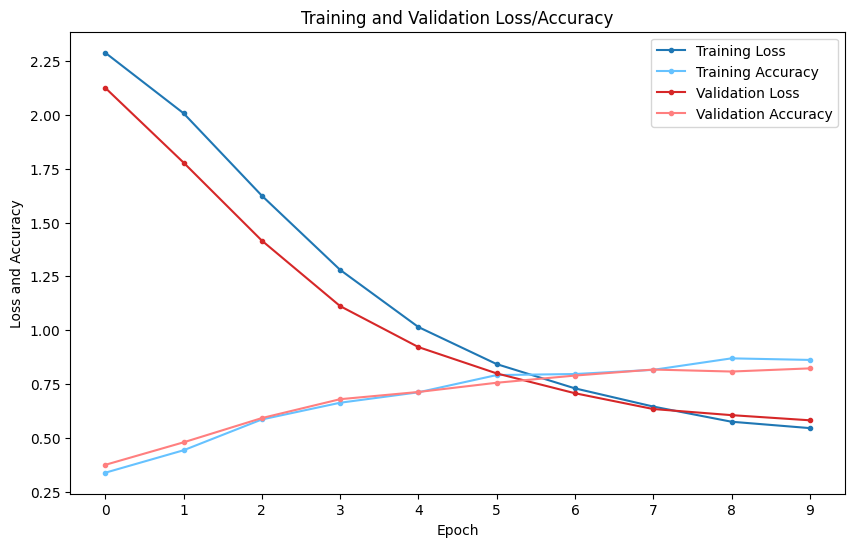


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.5978 | Final Test Accuracy: 0.8162
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2468 | Val Loss: 2.0466 | Training Accuracy: 0.2816 | Val Accuracy: 0.2740
Epoch 02 | Training Loss: 1.8995 | Val Loss: 1.6889 | Training Accuracy: 0.4466 | Val Accuracy: 0.4472
Epoch 03 | Training Loss: 1.5648 | Val Loss: 1.4148 | Training Accuracy: 0.4709 | Val Accuracy: 0.5119
Epoch 04 | Training Loss: 1.3070 | Val Loss: 1.2548 | Training Accuracy: 0.5922 | Val Accuracy: 0.5535
Epoch 05 | Training Loss: 1.1340 | Val Loss: 1.0919 | Training Accuracy: 0.6311 | Val Accuracy: 0.6054
Epoch 06 | Training Loss: 0.9799 | Val Loss: 0.9734 | Training Accuracy: 0.6966 | Val Accuracy: 0.6376
Epoch 07 | Training Loss: 0.8516 | Val Loss: 0.8609 | Training Accuracy: 0.7306 | Val Accuracy: 0.6822
Epoch 08 | Training Loss: 0.7231 | Val L

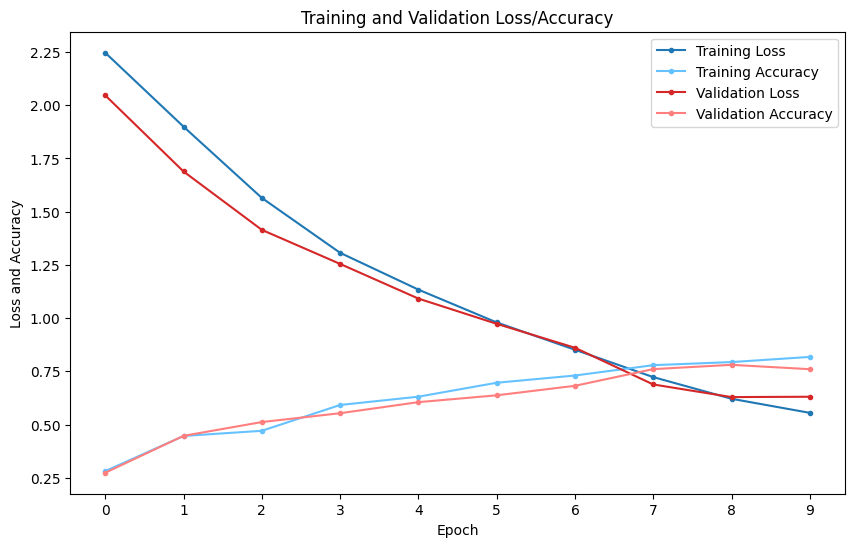


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 0.6364 | Final Test Accuracy: 0.7621
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3713 | Val Loss: 2.1028 | Training Accuracy: 0.2913 | Val Accuracy: 0.4090
Epoch 02 | Training Loss: 1.9072 | Val Loss: 1.6733 | Training Accuracy: 0.4563 | Val Accuracy: 0.5323
Epoch 03 | Training Loss: 1.5316 | Val Loss: 1.3229 | Training Accuracy: 0.6408 | Val Accuracy: 0.6660
Epoch 04 | Training Loss: 1.2116 | Val Loss: 1.0780 | Training Accuracy: 0.6675 | Val Accuracy: 0.6795
Epoch 05 | Training Loss: 0.9881 | Val Loss: 0.8853 | Training Accuracy: 0.7451 | Val Accuracy: 0.7428
Epoch 06 | Training Loss: 0.8349 | Val Loss: 0.7698 | Training Accuracy: 0.7549 | Val Accuracy: 0.7988
Epoch 07 | Training Loss: 0.7236 | Val Loss: 0.6924 | Training Accuracy: 0.7840 | Val Accuracy: 0.7756
Epoch 08 | Training Loss: 0.6485 | Val Lo

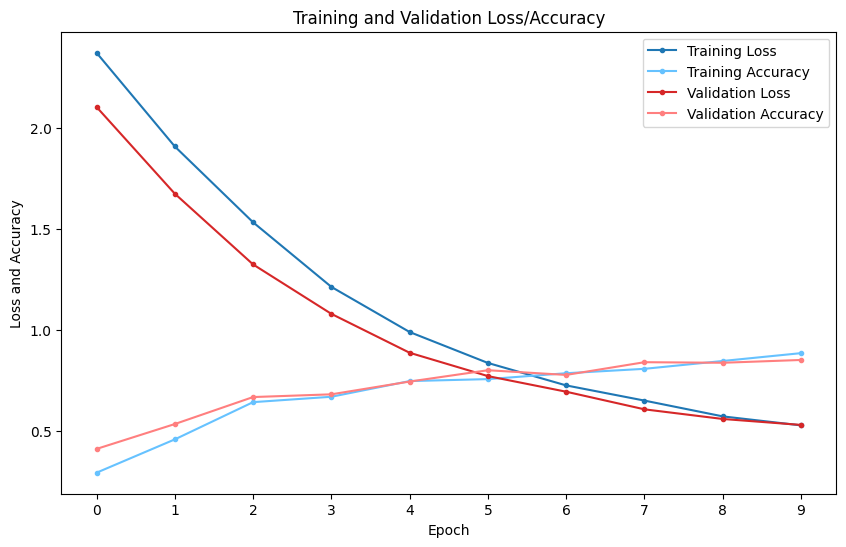


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.5482 | Final Test Accuracy: 0.8414
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3397 | Val Loss: 2.0795 | Training Accuracy: 0.2209 | Val Accuracy: 0.3434
Epoch 02 | Training Loss: 1.9502 | Val Loss: 1.7295 | Training Accuracy: 0.4417 | Val Accuracy: 0.4541
Epoch 03 | Training Loss: 1.5831 | Val Loss: 1.4043 | Training Accuracy: 0.5752 | Val Accuracy: 0.5484
Epoch 04 | Training Loss: 1.2880 | Val Loss: 1.1432 | Training Accuracy: 0.6068 | Val Accuracy: 0.6315
Epoch 05 | Training Loss: 1.0696 | Val Loss: 1.0008 | Training Accuracy: 0.6141 | Val Accuracy: 0.6698
Epoch 06 | Training Loss: 0.9199 | Val Loss: 0.9281 | Training Accuracy: 0.7015 | Val Accuracy: 0.6783
Epoch 07 | Training Loss: 0.8160 | Val Loss: 0.8163 | Training Accuracy: 0.7330 | Val Accuracy: 0.7178
Epoch 08 | Training Loss: 0.7124 | Val Los

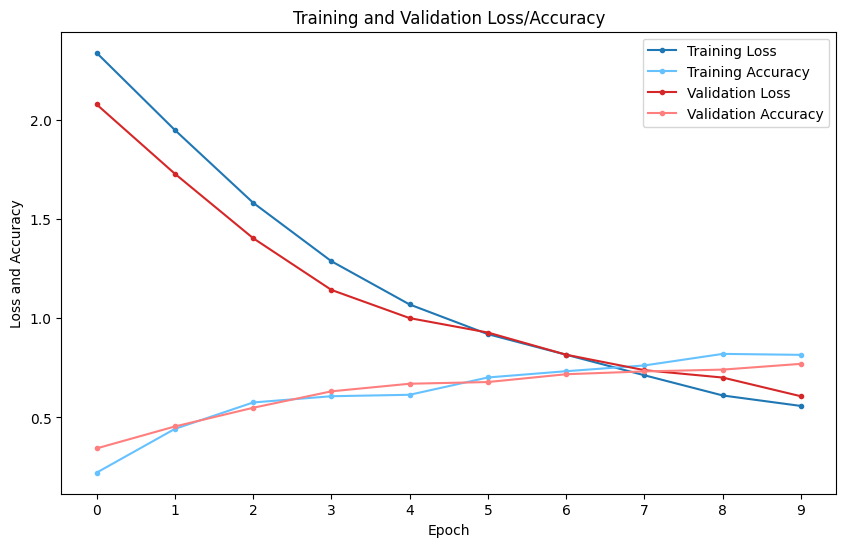


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.6151 | Final Test Accuracy: 0.7724
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.5978
Final Test Accuracy: 0.8162

Multiplicative LSTM
Final Test Loss: 0.6364
Final Test Accuracy: 0.7621

Standard GRU
Final Test Loss: 0.5482
Final Test Accuracy: 0.8414

Multiplicative GRU
Final Test Loss: 0.6151
Final Test Accuracy: 0.7724

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2679 | Val Loss: 2.1111 | Training Accuracy: 0.3762 | Val Accuracy: 0.3145
Epoch 02 | Training Loss: 1.9701 | Val Loss: 1.7373 | Training Accuracy: 0.4757 | Val Accuracy: 0.5483
Epoch 03 | Training Loss: 1.5753 | Val Loss: 1.3543 | Training Accuracy: 0.5850 | Val Accuracy: 0.6129
Epoch 04 | Training Loss: 1.2263 | Val Loss: 1.0887 | Training Accuracy: 0.6845 | Val Accuracy: 0.6657
Epo

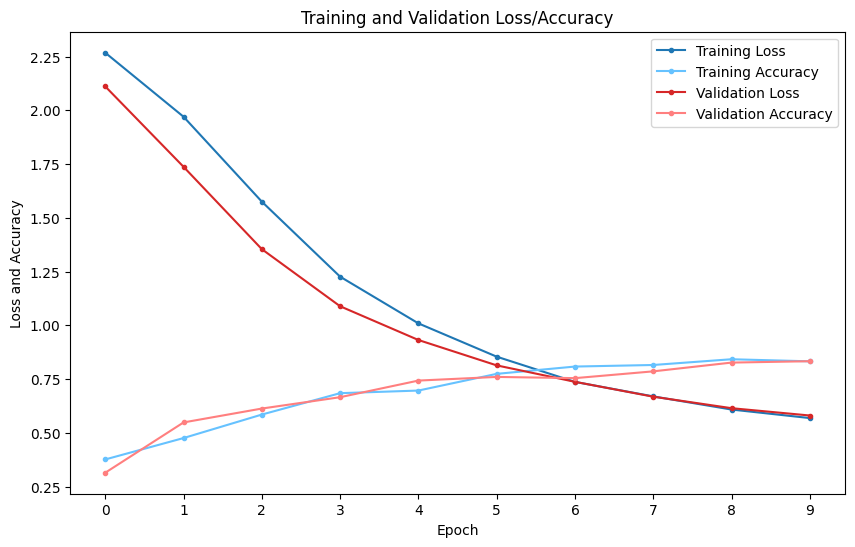


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.5971 | Accuracy: 0.8230
Segment 02/02 | Loss: 0.5962 | Accuracy: 0.8286

Final Test Loss: 0.5967 | Final Test Accuracy: 0.8258
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2674 | Val Loss: 2.0865 | Training Accuracy: 0.2573 | Val Accuracy: 0.2333
Epoch 02 | Training Loss: 1.9270 | Val Loss: 1.6758 | Training Accuracy: 0.4417 | Val Accuracy: 0.4736
Epoch 03 | Training Loss: 1.5310 | Val Loss: 1.3139 | Training Accuracy: 0.5485 | Val Accuracy: 0.5554
Epoch 04 | Training Loss: 1.1844 | Val Loss: 1.0576 | Training Accuracy: 0.6529 | Val Accuracy: 0.6415
Epoch 05 | Training Loss: 0.9822 | Val Loss: 0.8688 | Training Accuracy: 0.6772 | Val Accuracy: 0.7113
Epoch 06 | Training Loss: 0.8163 | Val Loss: 0.7913 | Training Accuracy: 0.7403 | Val Accuracy: 0.7269
Epoch 07 | Training Loss: 0.7120 | Val Loss: 0.

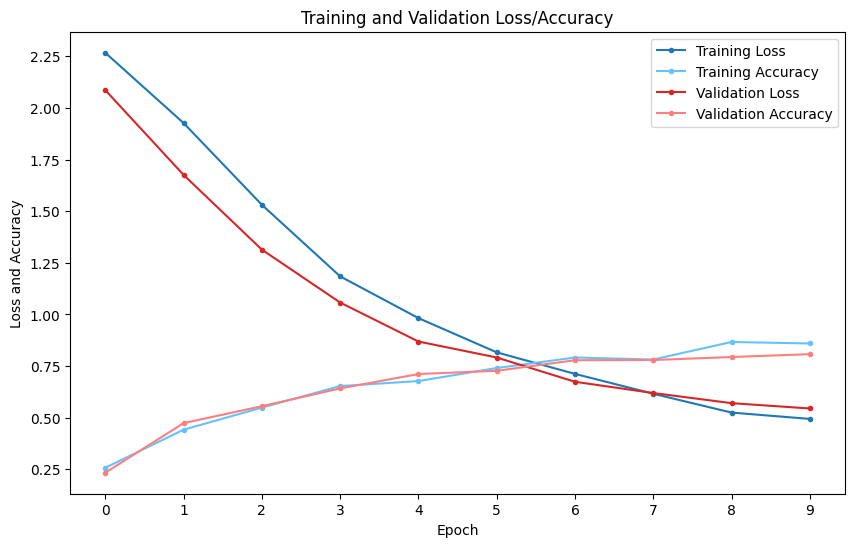


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.5806 | Accuracy: 0.7865
Segment 02/02 | Loss: 0.5755 | Accuracy: 0.7854

Final Test Loss: 0.5780 | Final Test Accuracy: 0.7860
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2839 | Val Loss: 1.9869 | Training Accuracy: 0.4005 | Val Accuracy: 0.3913
Epoch 02 | Training Loss: 1.8182 | Val Loss: 1.5711 | Training Accuracy: 0.5801 | Val Accuracy: 0.5867
Epoch 03 | Training Loss: 1.4342 | Val Loss: 1.2266 | Training Accuracy: 0.6068 | Val Accuracy: 0.6254
Epoch 04 | Training Loss: 1.1316 | Val Loss: 1.0001 | Training Accuracy: 0.6942 | Val Accuracy: 0.6981
Epoch 05 | Training Loss: 0.9169 | Val Loss: 0.8218 | Training Accuracy: 0.7500 | Val Accuracy: 0.7752
Epoch 06 | Training Loss: 0.7496 | Val Loss: 0.7073 | Training Accuracy: 0.8252 | Val Accuracy: 0.8061
Epoch 07 | Training Loss: 0.6507 | Val Loss: 0.6

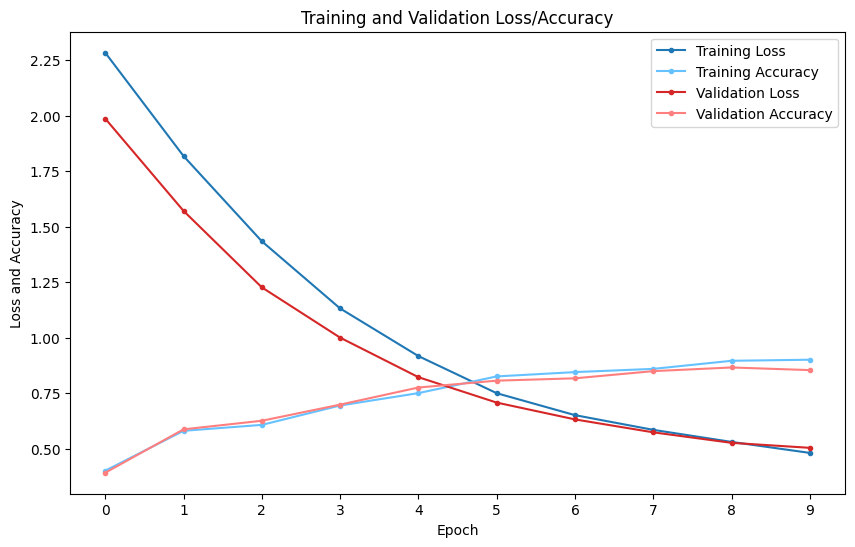


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.5195 | Accuracy: 0.8503
Segment 02/02 | Loss: 0.5072 | Accuracy: 0.8527

Final Test Loss: 0.5133 | Final Test Accuracy: 0.8515
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2363 | Val Loss: 1.9781 | Training Accuracy: 0.3350 | Val Accuracy: 0.3382
Epoch 02 | Training Loss: 1.8537 | Val Loss: 1.6236 | Training Accuracy: 0.4102 | Val Accuracy: 0.4652
Epoch 03 | Training Loss: 1.5203 | Val Loss: 1.3354 | Training Accuracy: 0.5121 | Val Accuracy: 0.5604
Epoch 04 | Training Loss: 1.2662 | Val Loss: 1.1493 | Training Accuracy: 0.6214 | Val Accuracy: 0.6083
Epoch 05 | Training Loss: 1.0803 | Val Loss: 1.0322 | Training Accuracy: 0.6553 | Val Accuracy: 0.6426
Epoch 06 | Training Loss: 0.9354 | Val Loss: 0.8966 | Training Accuracy: 0.6990 | Val Accuracy: 0.6901
Epoch 07 | Training Loss: 0.8120 | Val Loss: 0.84

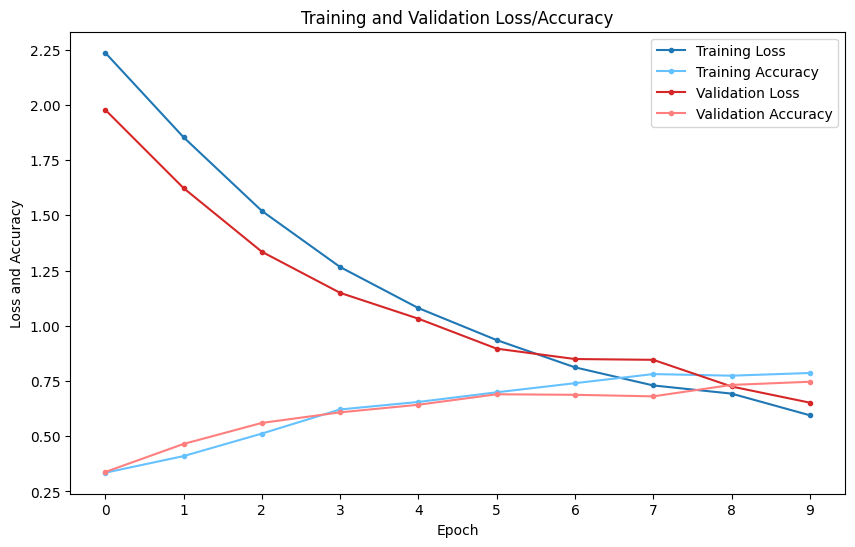


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 0.6720 | Accuracy: 0.7460
Segment 02/02 | Loss: 0.6645 | Accuracy: 0.7483

Final Test Loss: 0.6683 | Final Test Accuracy: 0.7471
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.5967
Final Test Accuracy: 0.8258

Multiplicative LSTM
Final Test Loss: 0.5780
Final Test Accuracy: 0.7860

Standard GRU
Final Test Loss: 0.5133
Final Test Accuracy: 0.8515

Multiplicative GRU
Final Test Loss: 0.6683
Final Test Accuracy: 0.7471

Training Standard LSTM:
Epoch 01 | Training Loss: 2.3063 | Val Loss: 2.1407 | Training Accuracy: 0.3544 | Val Accuracy: 0.3467
Epoch 02 | Training Loss: 2.0138 | Val Loss: 1.7944 | Training Accuracy: 0.4345 | Val Accuracy: 0.5089
Epoch 03 | Training Loss: 1.6510 | Val Loss: 1.4349 | Training Accuracy: 0.5364 | Val Accuracy: 0.5955
Epoch 04 |

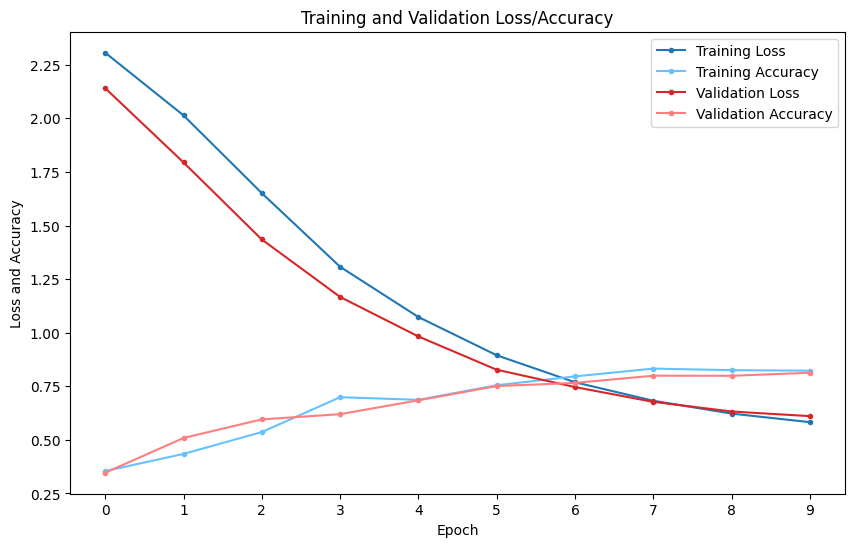


Test Sequence Length: 500
Testing Standard LSTM:
Segment 01/05 | Loss: 0.6275 | Accuracy: 0.8115
Segment 02/05 | Loss: 0.6127 | Accuracy: 0.8100
Segment 03/05 | Loss: 0.6104 | Accuracy: 0.8162
Segment 04/05 | Loss: 0.6118 | Accuracy: 0.8214
Segment 05/05 | Loss: 0.6228 | Accuracy: 0.8120

Final Test Loss: 0.6170 | Final Test Accuracy: 0.8142
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2697 | Val Loss: 2.0733 | Training Accuracy: 0.2063 | Val Accuracy: 0.2624
Epoch 02 | Training Loss: 1.9146 | Val Loss: 1.7137 | Training Accuracy: 0.4272 | Val Accuracy: 0.4306
Epoch 03 | Training Loss: 1.5444 | Val Loss: 1.4144 | Training Accuracy: 0.5510 | Val Accuracy: 0.5201
Epoch 04 | Training Loss: 1.2948 | Val Loss: 1.1708 | Training Accuracy: 0.5558 | Val Accuracy: 0.5901
Epoch 05 | Training Loss: 1.0765 | Val Loss: 1.0618 | Training Accuracy: 0.6432 | Val Accuracy: 0.6246
Epoch 

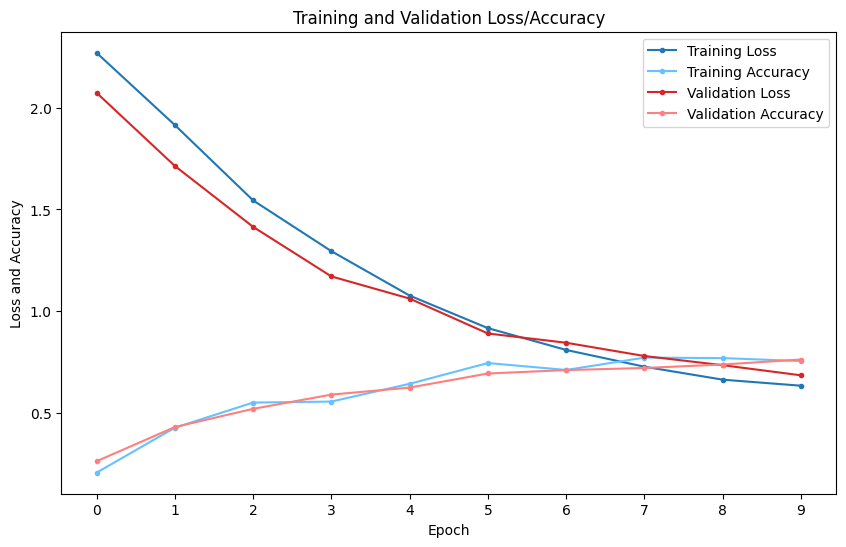


Test Sequence Length: 500
Testing Multiplicative LSTM:
Segment 01/05 | Loss: 0.7065 | Accuracy: 0.7558
Segment 02/05 | Loss: 0.7015 | Accuracy: 0.7530
Segment 03/05 | Loss: 0.6944 | Accuracy: 0.7597
Segment 04/05 | Loss: 0.7159 | Accuracy: 0.7489
Segment 05/05 | Loss: 0.7020 | Accuracy: 0.7544

Final Test Loss: 0.7041 | Final Test Accuracy: 0.7544
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3265 | Val Loss: 2.0752 | Training Accuracy: 0.2791 | Val Accuracy: 0.3692
Epoch 02 | Training Loss: 1.9218 | Val Loss: 1.6961 | Training Accuracy: 0.4320 | Val Accuracy: 0.4991
Epoch 03 | Training Loss: 1.5651 | Val Loss: 1.3621 | Training Accuracy: 0.5413 | Val Accuracy: 0.5883
Epoch 04 | Training Loss: 1.2460 | Val Loss: 1.1072 | Training Accuracy: 0.6796 | Val Accuracy: 0.6714
Epoch 05 | Training Loss: 1.0137 | Val Loss: 0.9124 | Training Accuracy: 0.7160 | Val Accuracy: 0.7270
Epoch 0

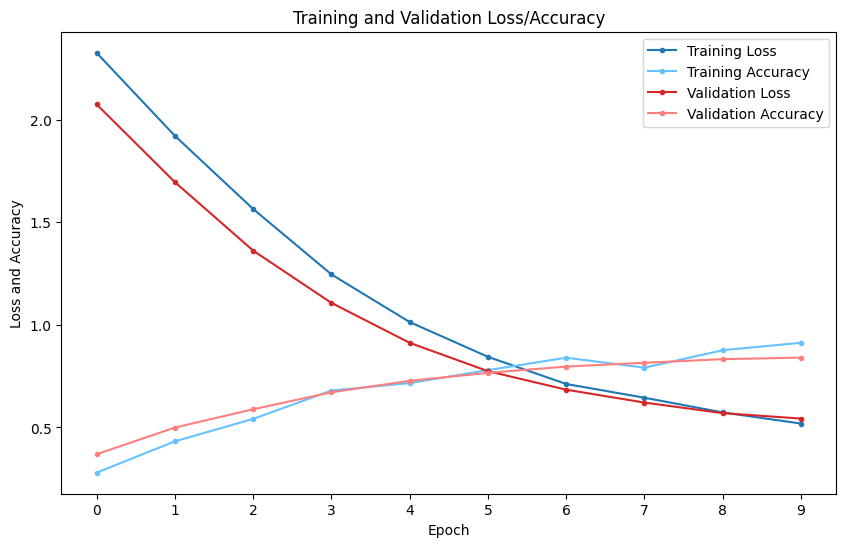


Test Sequence Length: 500
Testing Standard GRU:
Segment 01/05 | Loss: 0.5513 | Accuracy: 0.8392
Segment 02/05 | Loss: 0.5536 | Accuracy: 0.8442
Segment 03/05 | Loss: 0.5483 | Accuracy: 0.8436
Segment 04/05 | Loss: 0.5508 | Accuracy: 0.8361
Segment 05/05 | Loss: 0.5530 | Accuracy: 0.8384

Final Test Loss: 0.5514 | Final Test Accuracy: 0.8403
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3489 | Val Loss: 2.0636 | Training Accuracy: 0.2379 | Val Accuracy: 0.2888
Epoch 02 | Training Loss: 1.9111 | Val Loss: 1.6678 | Training Accuracy: 0.3956 | Val Accuracy: 0.4340
Epoch 03 | Training Loss: 1.4858 | Val Loss: 1.3018 | Training Accuracy: 0.5631 | Val Accuracy: 0.5499
Epoch 04 | Training Loss: 1.1542 | Val Loss: 1.1197 | Training Accuracy: 0.6432 | Val Accuracy: 0.5895
Epoch 05 | Training Loss: 0.9896 | Val Loss: 0.9696 | Training Accuracy: 0.6893 | Val Accuracy: 0.6450
Epoch 06

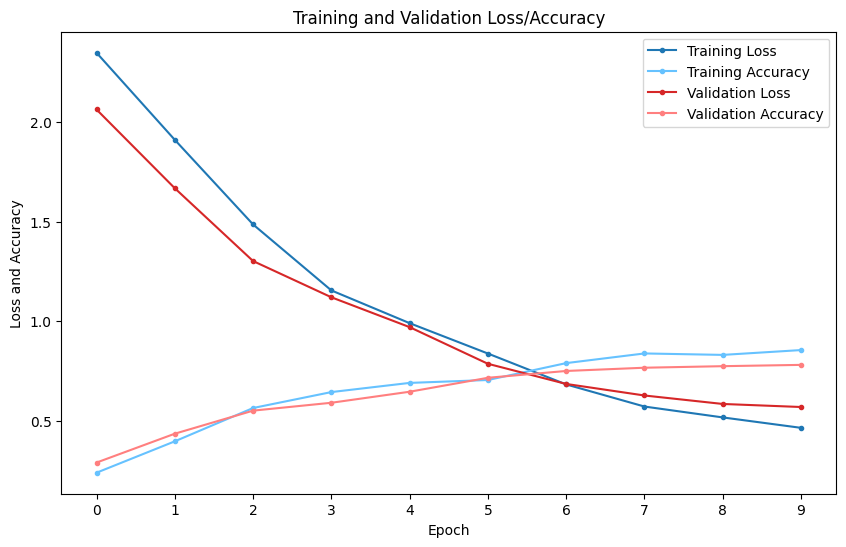


Test Sequence Length: 500
Testing Multiplicative GRU:
Segment 01/05 | Loss: 0.5805 | Accuracy: 0.7755
Segment 02/05 | Loss: 0.5602 | Accuracy: 0.7848
Segment 03/05 | Loss: 0.5637 | Accuracy: 0.7793
Segment 04/05 | Loss: 0.5590 | Accuracy: 0.7840
Segment 05/05 | Loss: 0.5550 | Accuracy: 0.7849

Final Test Loss: 0.5637 | Final Test Accuracy: 0.7817
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 500 ***
Standard LSTM
Final Test Loss: 0.6170
Final Test Accuracy: 0.8142

Multiplicative LSTM
Final Test Loss: 0.7041
Final Test Accuracy: 0.7544

Standard GRU
Final Test Loss: 0.5514
Final Test Accuracy: 0.8403

Multiplicative GRU
Final Test Loss: 0.5637
Final Test Accuracy: 0.7817

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2601 | Val Loss: 2.0905 | Training Accuracy: 0.2670 | Val Accuracy: 0.2076
Epoch 02 | Training Loss: 1.9421 | Val Loss: 1.7083 | Training Accuracy:

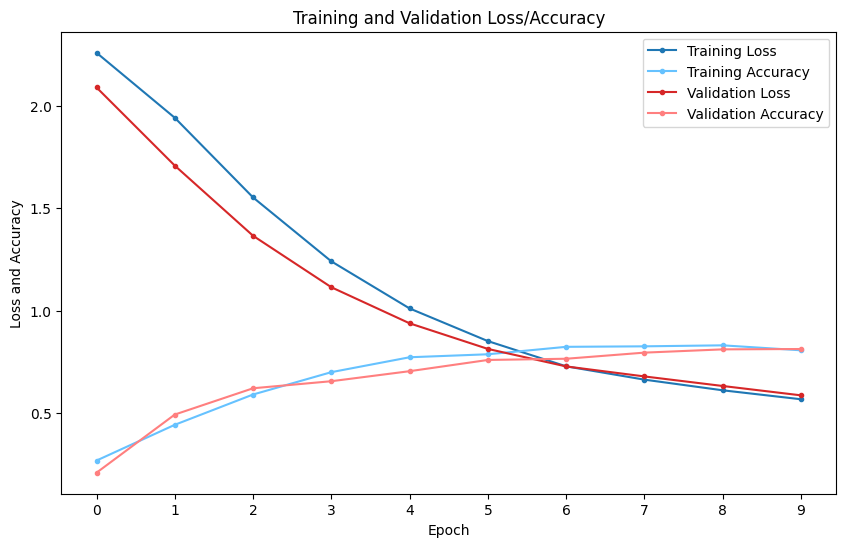


Test Sequence Length: 1000
Testing Standard LSTM:
Segment 01/10 | Loss: 0.5966 | Accuracy: 0.8083
Segment 02/10 | Loss: 0.5907 | Accuracy: 0.8144
Segment 03/10 | Loss: 0.5881 | Accuracy: 0.8111
Segment 04/10 | Loss: 0.5909 | Accuracy: 0.8155
Segment 05/10 | Loss: 0.5884 | Accuracy: 0.8124
Segment 06/10 | Loss: 0.5855 | Accuracy: 0.8190
Segment 07/10 | Loss: 0.5832 | Accuracy: 0.8169
Segment 08/10 | Loss: 0.5876 | Accuracy: 0.8126
Segment 09/10 | Loss: 0.5893 | Accuracy: 0.8165
Segment 10/10 | Loss: 0.5913 | Accuracy: 0.8129

Final Test Loss: 0.5892 | Final Test Accuracy: 0.8140
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2547 | Val Loss: 2.0665 | Training Accuracy: 0.2379 | Val Accuracy: 0.2427
Epoch 02 | Training Loss: 1.9270 | Val Loss: 1.7132 | Training Accuracy: 0.4563 | Val Accuracy: 0.4444
Epoch 03 | Training Loss: 1.6148 | Val Loss: 1.4579 | Training Accuracy: 0

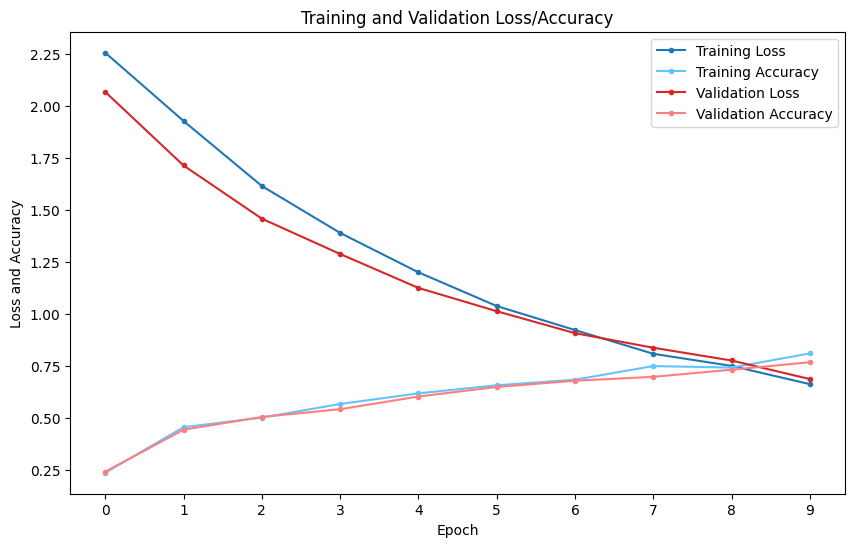


Test Sequence Length: 1000
Testing Multiplicative LSTM:
Segment 01/10 | Loss: 0.6971 | Accuracy: 0.7613
Segment 02/10 | Loss: 0.7111 | Accuracy: 0.7514
Segment 03/10 | Loss: 0.7062 | Accuracy: 0.7572
Segment 04/10 | Loss: 0.6987 | Accuracy: 0.7664
Segment 05/10 | Loss: 0.6938 | Accuracy: 0.7637
Segment 06/10 | Loss: 0.7032 | Accuracy: 0.7559
Segment 07/10 | Loss: 0.6993 | Accuracy: 0.7619
Segment 08/10 | Loss: 0.6986 | Accuracy: 0.7691
Segment 09/10 | Loss: 0.6863 | Accuracy: 0.7661
Segment 10/10 | Loss: 0.6885 | Accuracy: 0.7688

Final Test Loss: 0.6983 | Final Test Accuracy: 0.7622
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3397 | Val Loss: 2.0271 | Training Accuracy: 0.2549 | Val Accuracy: 0.4022
Epoch 02 | Training Loss: 1.8850 | Val Loss: 1.6131 | Training Accuracy: 0.4320 | Val Accuracy: 0.5263
Epoch 03 | Training Loss: 1.4815 | Val Loss: 1.2640 | Training Accuracy: 0.

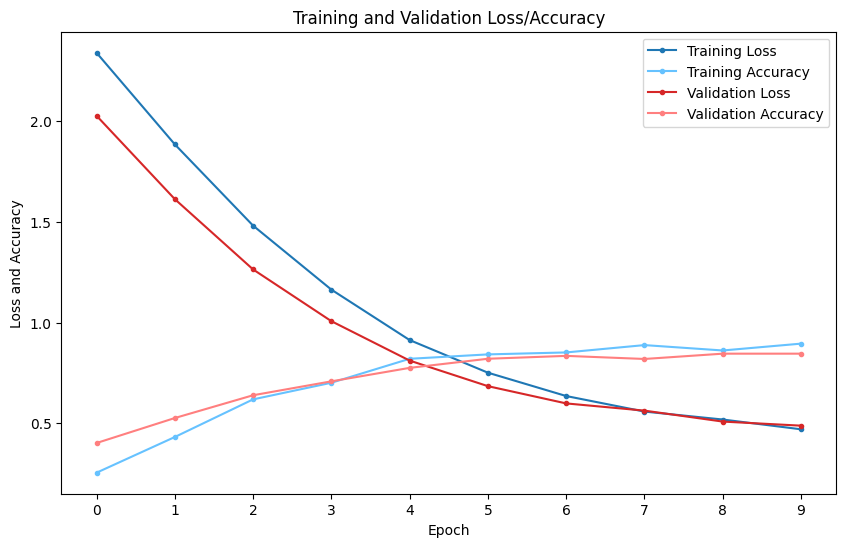


Test Sequence Length: 1000
Testing Standard GRU:
Segment 01/10 | Loss: 0.5120 | Accuracy: 0.8359
Segment 02/10 | Loss: 0.5144 | Accuracy: 0.8371
Segment 03/10 | Loss: 0.5073 | Accuracy: 0.8444
Segment 04/10 | Loss: 0.5062 | Accuracy: 0.8425
Segment 05/10 | Loss: 0.5065 | Accuracy: 0.8409
Segment 06/10 | Loss: 0.5182 | Accuracy: 0.8336
Segment 07/10 | Loss: 0.5081 | Accuracy: 0.8420
Segment 08/10 | Loss: 0.5122 | Accuracy: 0.8394
Segment 09/10 | Loss: 0.4968 | Accuracy: 0.8535
Segment 10/10 | Loss: 0.5009 | Accuracy: 0.8473

Final Test Loss: 0.5083 | Final Test Accuracy: 0.8417
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3055 | Val Loss: 2.0913 | Training Accuracy: 0.2379 | Val Accuracy: 0.2750
Epoch 02 | Training Loss: 1.9765 | Val Loss: 1.8042 | Training Accuracy: 0.3544 | Val Accuracy: 0.3810
Epoch 03 | Training Loss: 1.6985 | Val Loss: 1.6848 | Training Accuracy: 0.4

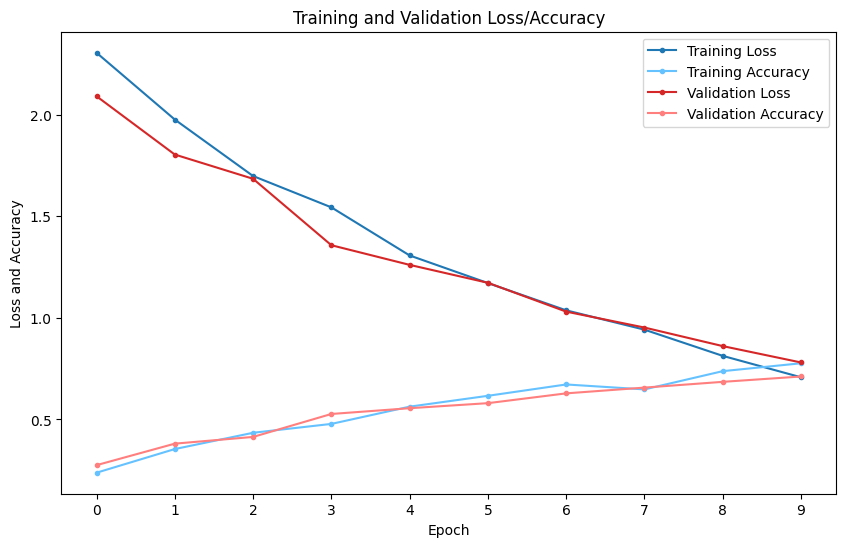


Test Sequence Length: 1000
Testing Multiplicative GRU:
Segment 01/10 | Loss: 0.8029 | Accuracy: 0.7007
Segment 02/10 | Loss: 0.8082 | Accuracy: 0.6930
Segment 03/10 | Loss: 0.8035 | Accuracy: 0.7008
Segment 04/10 | Loss: 0.8185 | Accuracy: 0.6950
Segment 05/10 | Loss: 0.7955 | Accuracy: 0.7044
Segment 06/10 | Loss: 0.8114 | Accuracy: 0.6975
Segment 07/10 | Loss: 0.7973 | Accuracy: 0.7002
Segment 08/10 | Loss: 0.8017 | Accuracy: 0.7009
Segment 09/10 | Loss: 0.7906 | Accuracy: 0.7009
Segment 10/10 | Loss: 0.7964 | Accuracy: 0.7006

Final Test Loss: 0.8026 | Final Test Accuracy: 0.6994
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 1/3 on sequence length of 1000 ***
Standard LSTM
Final Test Loss: 0.5892
Final Test Accuracy: 0.8140

Multiplicative LSTM
Final Test Loss: 0.6983
Final Test Accuracy: 0.7622

Standard GRU
Final Test Loss: 0.5083
Final Test Accuracy: 0.8417

Multiplicative GRU
Final Test

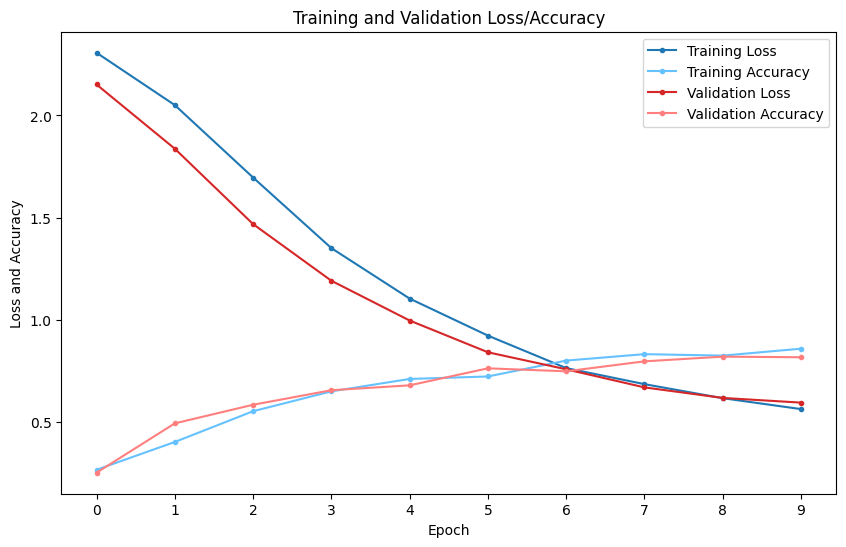


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.6128 | Final Test Accuracy: 0.8096
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2526 | Val Loss: 2.0653 | Training Accuracy: 0.3350 | Val Accuracy: 0.3099
Epoch 02 | Training Loss: 1.8904 | Val Loss: 1.6475 | Training Accuracy: 0.4417 | Val Accuracy: 0.4422
Epoch 03 | Training Loss: 1.4900 | Val Loss: 1.3361 | Training Accuracy: 0.5388 | Val Accuracy: 0.5450
Epoch 04 | Training Loss: 1.2306 | Val Loss: 1.1487 | Training Accuracy: 0.6335 | Val Accuracy: 0.5937
Epoch 05 | Training Loss: 1.0248 | Val Loss: 0.9446 | Training Accuracy: 0.6553 | Val Accuracy: 0.6699
Epoch 06 | Training Loss: 0.8421 | Val Loss: 0.8037 | Training Accuracy: 0.7282 | Val Accuracy: 0.7161
Epoch 07 | Training Loss: 0.7208 | Val Loss: 0.7249 | Training Accuracy: 0.7621 | Val Accuracy: 0.7315
Epoch 08 | Training Loss: 0.6362 | Val L

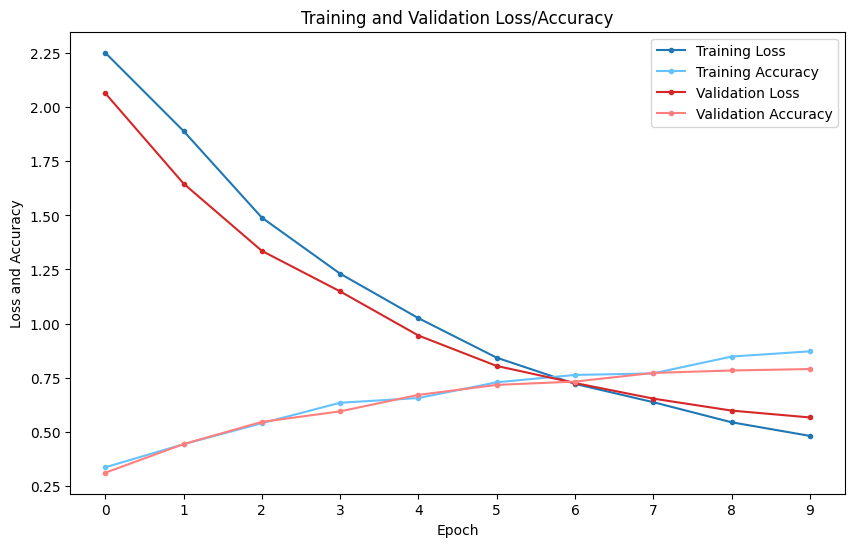


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 0.5975 | Final Test Accuracy: 0.7708
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3393 | Val Loss: 2.0724 | Training Accuracy: 0.2573 | Val Accuracy: 0.2642
Epoch 02 | Training Loss: 1.9241 | Val Loss: 1.6957 | Training Accuracy: 0.4320 | Val Accuracy: 0.4668
Epoch 03 | Training Loss: 1.5695 | Val Loss: 1.3659 | Training Accuracy: 0.6068 | Val Accuracy: 0.6143
Epoch 04 | Training Loss: 1.2477 | Val Loss: 1.1110 | Training Accuracy: 0.7184 | Val Accuracy: 0.6687
Epoch 05 | Training Loss: 1.0204 | Val Loss: 0.9260 | Training Accuracy: 0.7282 | Val Accuracy: 0.7410
Epoch 06 | Training Loss: 0.8474 | Val Loss: 0.7890 | Training Accuracy: 0.7791 | Val Accuracy: 0.7553
Epoch 07 | Training Loss: 0.7345 | Val Loss: 0.6973 | Training Accuracy: 0.8277 | Val Accuracy: 0.8007
Epoch 08 | Training Loss: 0.6411 | Val Lo

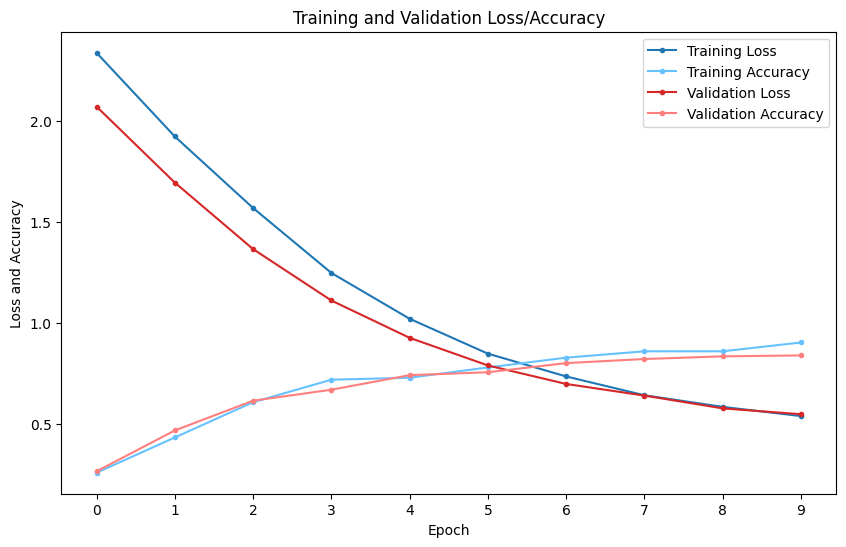


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.5662 | Final Test Accuracy: 0.8321
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2730 | Val Loss: 1.9820 | Training Accuracy: 0.3398 | Val Accuracy: 0.3597
Epoch 02 | Training Loss: 1.8133 | Val Loss: 1.6511 | Training Accuracy: 0.4515 | Val Accuracy: 0.4336
Epoch 03 | Training Loss: 1.4994 | Val Loss: 1.3329 | Training Accuracy: 0.5194 | Val Accuracy: 0.5366
Epoch 04 | Training Loss: 1.2200 | Val Loss: 1.1971 | Training Accuracy: 0.6432 | Val Accuracy: 0.5833
Epoch 05 | Training Loss: 1.0450 | Val Loss: 0.9923 | Training Accuracy: 0.6893 | Val Accuracy: 0.6523
Epoch 06 | Training Loss: 0.8974 | Val Loss: 0.8892 | Training Accuracy: 0.7209 | Val Accuracy: 0.6970
Epoch 07 | Training Loss: 0.8128 | Val Loss: 0.8322 | Training Accuracy: 0.7209 | Val Accuracy: 0.7149
Epoch 08 | Training Loss: 0.7288 | Val Los

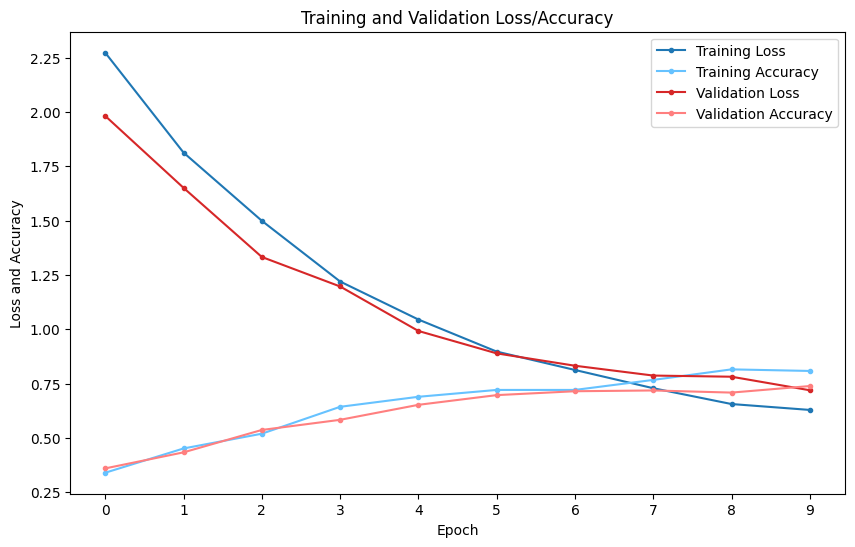


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.7488 | Final Test Accuracy: 0.7249
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.6128
Final Test Accuracy: 0.8096

Multiplicative LSTM
Final Test Loss: 0.5975
Final Test Accuracy: 0.7708

Standard GRU
Final Test Loss: 0.5662
Final Test Accuracy: 0.8321

Multiplicative GRU
Final Test Loss: 0.7488
Final Test Accuracy: 0.7249

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2753 | Val Loss: 2.1168 | Training Accuracy: 0.3350 | Val Accuracy: 0.3438
Epoch 02 | Training Loss: 1.9783 | Val Loss: 1.7467 | Training Accuracy: 0.4563 | Val Accuracy: 0.5073
Epoch 03 | Training Loss: 1.5947 | Val Loss: 1.3801 | Training Accuracy: 0.5583 | Val Accuracy: 0.6292
Epoch 04 | Training Loss: 1.2532 | Val Loss: 1.1080 | Training Accuracy: 0.6748 | Val Accuracy: 0.6862
Epo

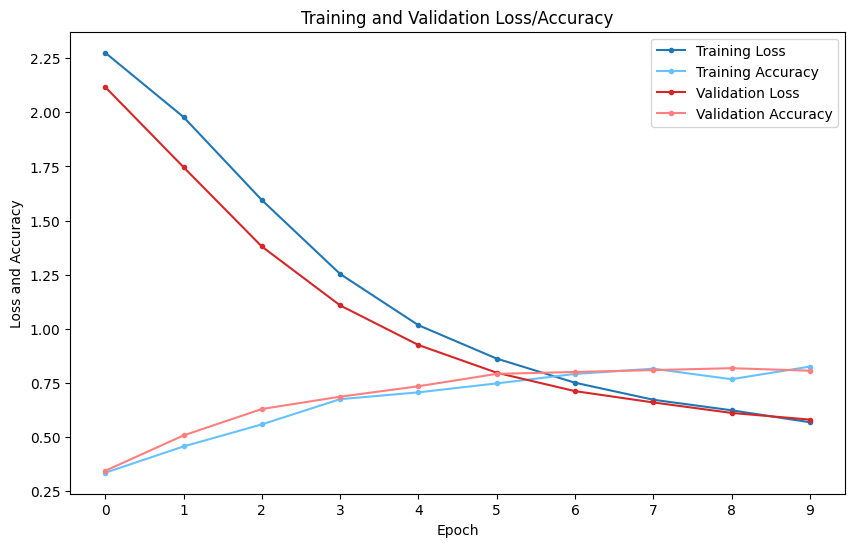


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.5971 | Accuracy: 0.8026
Segment 02/02 | Loss: 0.6017 | Accuracy: 0.7973

Final Test Loss: 0.5994 | Final Test Accuracy: 0.8000
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2156 | Val Loss: 1.9529 | Training Accuracy: 0.3058 | Val Accuracy: 0.3598
Epoch 02 | Training Loss: 1.8157 | Val Loss: 1.5900 | Training Accuracy: 0.4806 | Val Accuracy: 0.4696
Epoch 03 | Training Loss: 1.4579 | Val Loss: 1.3170 | Training Accuracy: 0.5485 | Val Accuracy: 0.5487
Epoch 04 | Training Loss: 1.2403 | Val Loss: 1.1428 | Training Accuracy: 0.6019 | Val Accuracy: 0.5972
Epoch 05 | Training Loss: 1.0679 | Val Loss: 1.0299 | Training Accuracy: 0.6189 | Val Accuracy: 0.6313
Epoch 06 | Training Loss: 0.9363 | Val Loss: 0.9604 | Training Accuracy: 0.6820 | Val Accuracy: 0.6393
Epoch 07 | Training Loss: 0.8439 | Val Loss: 0.

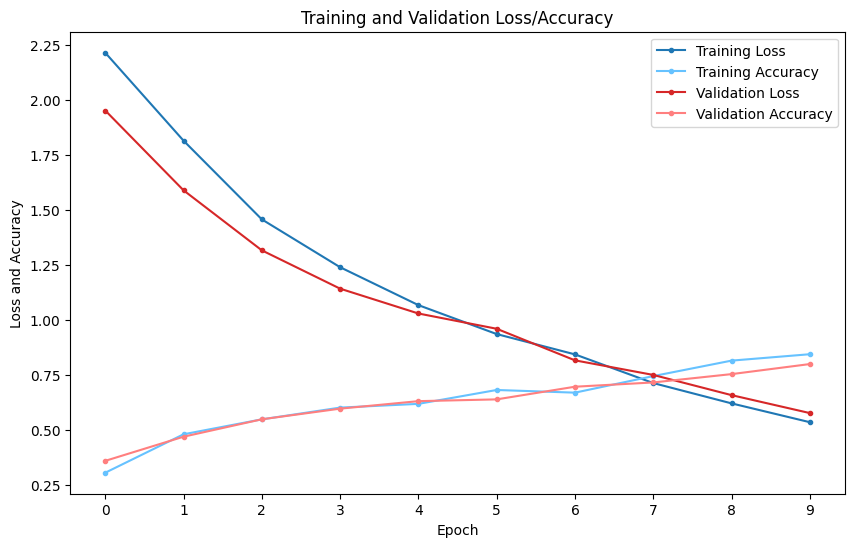


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.5978 | Accuracy: 0.7902
Segment 02/02 | Loss: 0.5941 | Accuracy: 0.7908

Final Test Loss: 0.5960 | Final Test Accuracy: 0.7905
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2620 | Val Loss: 1.9201 | Training Accuracy: 0.3204 | Val Accuracy: 0.4249
Epoch 02 | Training Loss: 1.7592 | Val Loss: 1.4865 | Training Accuracy: 0.5000 | Val Accuracy: 0.5529
Epoch 03 | Training Loss: 1.3474 | Val Loss: 1.1522 | Training Accuracy: 0.6942 | Val Accuracy: 0.6626
Epoch 04 | Training Loss: 1.0677 | Val Loss: 0.9306 | Training Accuracy: 0.6893 | Val Accuracy: 0.7214
Epoch 05 | Training Loss: 0.8638 | Val Loss: 0.7800 | Training Accuracy: 0.7597 | Val Accuracy: 0.7482
Epoch 06 | Training Loss: 0.7209 | Val Loss: 0.6645 | Training Accuracy: 0.8204 | Val Accuracy: 0.8134
Epoch 07 | Training Loss: 0.6232 | Val Loss: 0.6

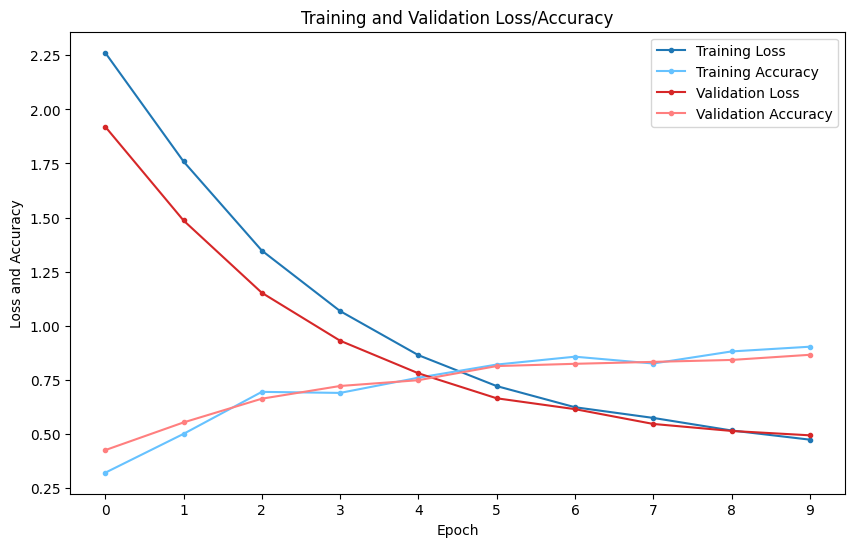


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.5112 | Accuracy: 0.8632
Segment 02/02 | Loss: 0.5097 | Accuracy: 0.8561

Final Test Loss: 0.5104 | Final Test Accuracy: 0.8597
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2677 | Val Loss: 2.1184 | Training Accuracy: 0.2524 | Val Accuracy: 0.2040
Epoch 02 | Training Loss: 2.0206 | Val Loss: 1.9460 | Training Accuracy: 0.3325 | Val Accuracy: 0.3250
Epoch 03 | Training Loss: 1.7947 | Val Loss: 1.6579 | Training Accuracy: 0.4320 | Val Accuracy: 0.4363
Epoch 04 | Training Loss: 1.5509 | Val Loss: 1.4755 | Training Accuracy: 0.4830 | Val Accuracy: 0.4901
Epoch 05 | Training Loss: 1.3371 | Val Loss: 1.3048 | Training Accuracy: 0.5631 | Val Accuracy: 0.5597
Epoch 06 | Training Loss: 1.1928 | Val Loss: 1.1429 | Training Accuracy: 0.6165 | Val Accuracy: 0.6025
Epoch 07 | Training Loss: 1.0619 | Val Loss: 1.02

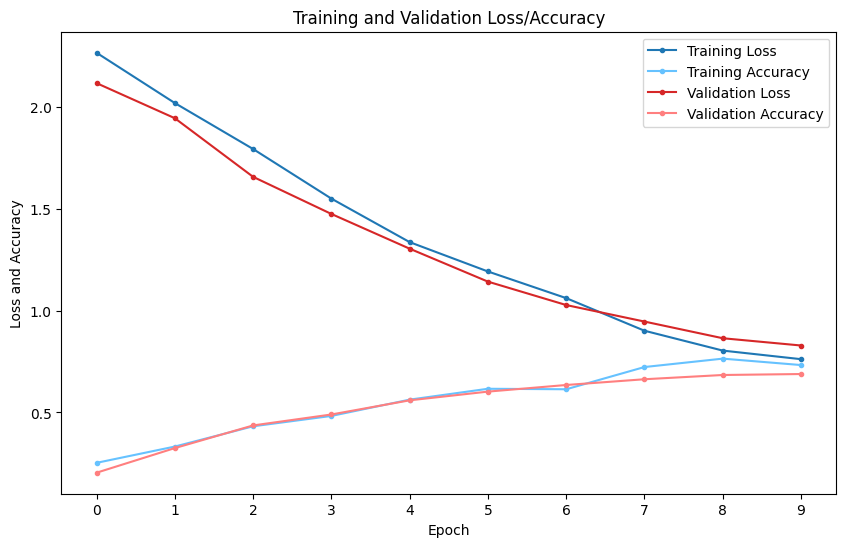


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 0.8491 | Accuracy: 0.6770
Segment 02/02 | Loss: 0.8514 | Accuracy: 0.6784

Final Test Loss: 0.8502 | Final Test Accuracy: 0.6777
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.5994
Final Test Accuracy: 0.8000

Multiplicative LSTM
Final Test Loss: 0.5960
Final Test Accuracy: 0.7905

Standard GRU
Final Test Loss: 0.5104
Final Test Accuracy: 0.8597

Multiplicative GRU
Final Test Loss: 0.8502
Final Test Accuracy: 0.6777

Training Standard LSTM:
Epoch 01 | Training Loss: 2.3020 | Val Loss: 2.1199 | Training Accuracy: 0.3180 | Val Accuracy: 0.3170
Epoch 02 | Training Loss: 2.0145 | Val Loss: 1.7977 | Training Accuracy: 0.4515 | Val Accuracy: 0.5383
Epoch 03 | Training Loss: 1.6611 | Val Loss: 1.4553 | Training Accuracy: 0.5971 | Val Accuracy: 0.5789
Epoch 04 |

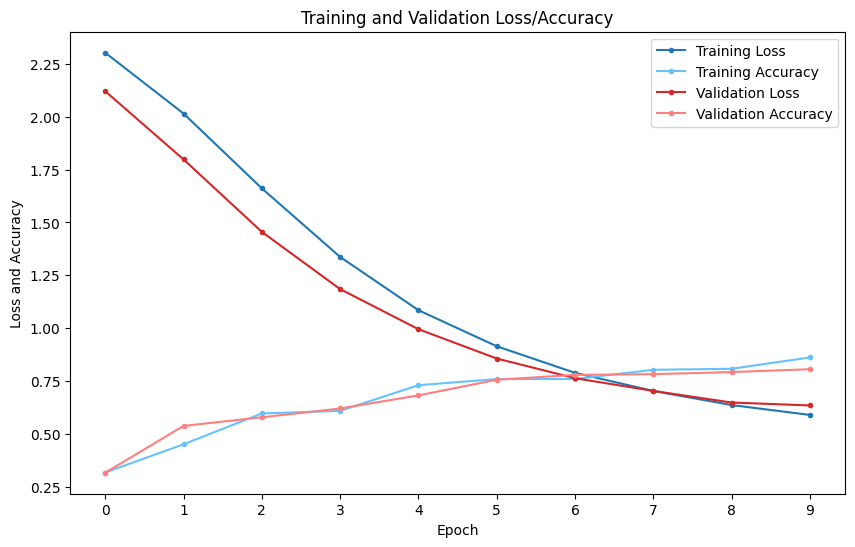


Test Sequence Length: 500
Testing Standard LSTM:
Segment 01/05 | Loss: 0.6436 | Accuracy: 0.7987
Segment 02/05 | Loss: 0.6382 | Accuracy: 0.7971
Segment 03/05 | Loss: 0.6356 | Accuracy: 0.8024
Segment 04/05 | Loss: 0.6356 | Accuracy: 0.8048
Segment 05/05 | Loss: 0.6359 | Accuracy: 0.8038

Final Test Loss: 0.6378 | Final Test Accuracy: 0.8014
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2641 | Val Loss: 2.0437 | Training Accuracy: 0.2233 | Val Accuracy: 0.3182
Epoch 02 | Training Loss: 1.9117 | Val Loss: 1.6605 | Training Accuracy: 0.4369 | Val Accuracy: 0.4460
Epoch 03 | Training Loss: 1.5219 | Val Loss: 1.3702 | Training Accuracy: 0.5413 | Val Accuracy: 0.5306
Epoch 04 | Training Loss: 1.2366 | Val Loss: 1.1445 | Training Accuracy: 0.6165 | Val Accuracy: 0.5995
Epoch 05 | Training Loss: 1.0374 | Val Loss: 0.9924 | Training Accuracy: 0.6942 | Val Accuracy: 0.6471
Epoch 

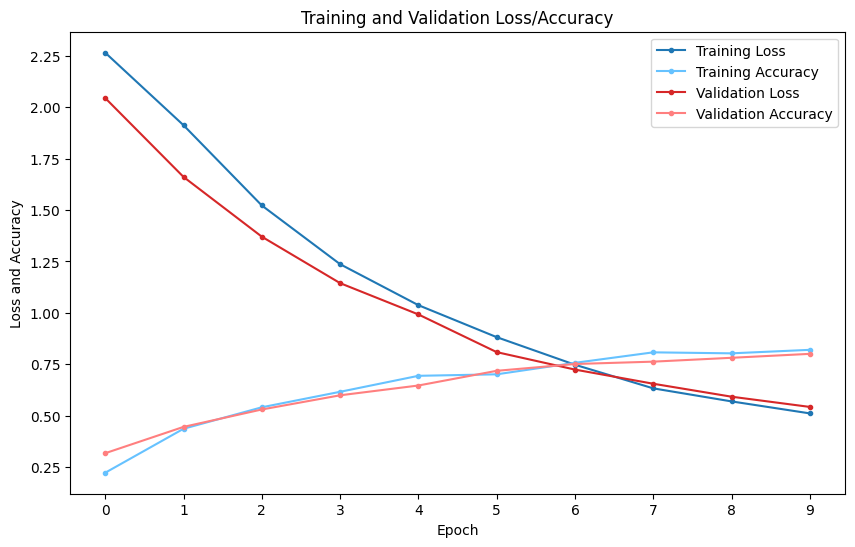


Test Sequence Length: 500
Testing Multiplicative LSTM:
Segment 01/05 | Loss: 0.5736 | Accuracy: 0.7883
Segment 02/05 | Loss: 0.5721 | Accuracy: 0.7847
Segment 03/05 | Loss: 0.5663 | Accuracy: 0.7881
Segment 04/05 | Loss: 0.5643 | Accuracy: 0.7872
Segment 05/05 | Loss: 0.5650 | Accuracy: 0.7870

Final Test Loss: 0.5683 | Final Test Accuracy: 0.7871
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3688 | Val Loss: 2.1087 | Training Accuracy: 0.2694 | Val Accuracy: 0.2838
Epoch 02 | Training Loss: 1.9740 | Val Loss: 1.7461 | Training Accuracy: 0.4175 | Val Accuracy: 0.4842
Epoch 03 | Training Loss: 1.6260 | Val Loss: 1.4166 | Training Accuracy: 0.5316 | Val Accuracy: 0.5918
Epoch 04 | Training Loss: 1.3138 | Val Loss: 1.1511 | Training Accuracy: 0.6408 | Val Accuracy: 0.6718
Epoch 05 | Training Loss: 1.0685 | Val Loss: 0.9359 | Training Accuracy: 0.6772 | Val Accuracy: 0.7388
Epoch 0

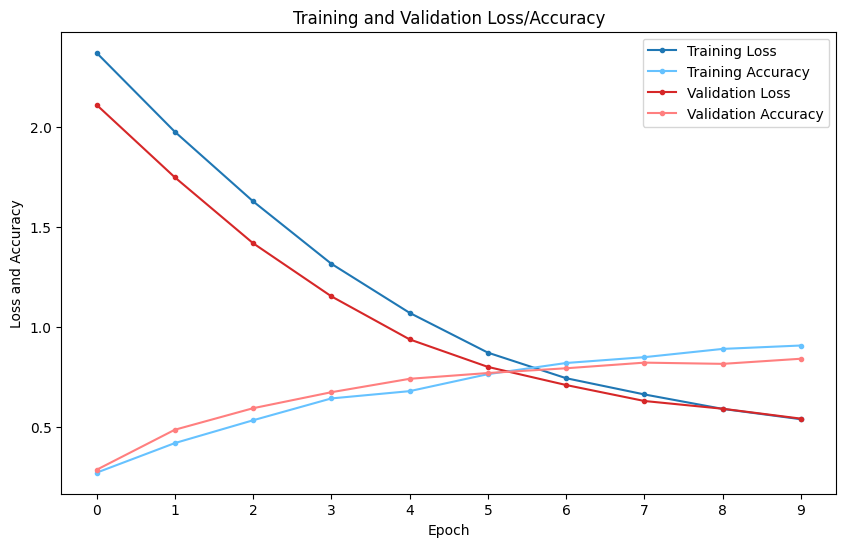


Test Sequence Length: 500
Testing Standard GRU:
Segment 01/05 | Loss: 0.5578 | Accuracy: 0.8357
Segment 02/05 | Loss: 0.5574 | Accuracy: 0.8316
Segment 03/05 | Loss: 0.5640 | Accuracy: 0.8286
Segment 04/05 | Loss: 0.5527 | Accuracy: 0.8373
Segment 05/05 | Loss: 0.5634 | Accuracy: 0.8276

Final Test Loss: 0.5591 | Final Test Accuracy: 0.8322
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3506 | Val Loss: 2.1116 | Training Accuracy: 0.1626 | Val Accuracy: 0.2767
Epoch 02 | Training Loss: 1.9894 | Val Loss: 1.7817 | Training Accuracy: 0.3714 | Val Accuracy: 0.3956
Epoch 03 | Training Loss: 1.6578 | Val Loss: 1.4900 | Training Accuracy: 0.4684 | Val Accuracy: 0.4882
Epoch 04 | Training Loss: 1.3436 | Val Loss: 1.2130 | Training Accuracy: 0.5583 | Val Accuracy: 0.5786
Epoch 05 | Training Loss: 1.1083 | Val Loss: 0.9765 | Training Accuracy: 0.6335 | Val Accuracy: 0.6673
Epoch 06

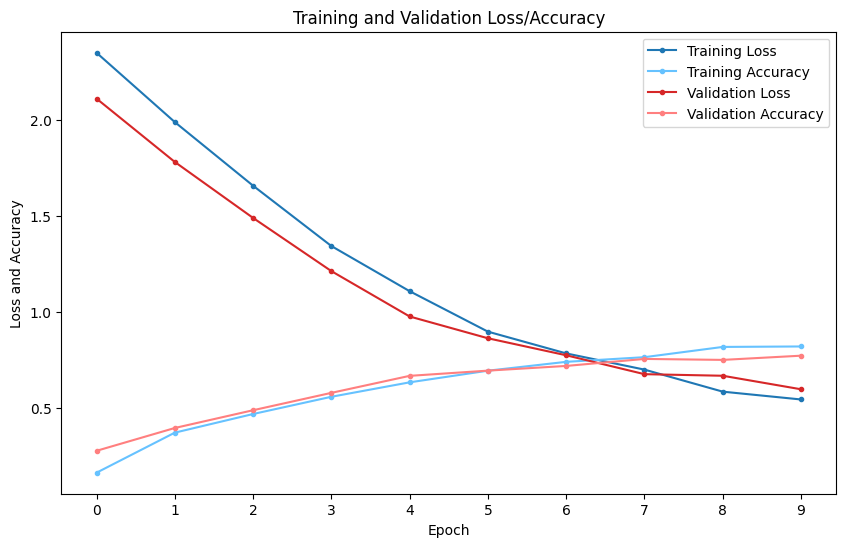


Test Sequence Length: 500
Testing Multiplicative GRU:
Segment 01/05 | Loss: 0.6257 | Accuracy: 0.7617
Segment 02/05 | Loss: 0.6145 | Accuracy: 0.7737
Segment 03/05 | Loss: 0.6206 | Accuracy: 0.7684
Segment 04/05 | Loss: 0.6132 | Accuracy: 0.7750
Segment 05/05 | Loss: 0.6203 | Accuracy: 0.7633

Final Test Loss: 0.6189 | Final Test Accuracy: 0.7684
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 500 ***
Standard LSTM
Final Test Loss: 0.6378
Final Test Accuracy: 0.8014

Multiplicative LSTM
Final Test Loss: 0.5683
Final Test Accuracy: 0.7871

Standard GRU
Final Test Loss: 0.5591
Final Test Accuracy: 0.8322

Multiplicative GRU
Final Test Loss: 0.6189
Final Test Accuracy: 0.7684

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2613 | Val Loss: 2.0800 | Training Accuracy: 0.3155 | Val Accuracy: 0.3053
Epoch 02 | Training Loss: 1.9324 | Val Loss: 1.7102 | Training Accuracy:

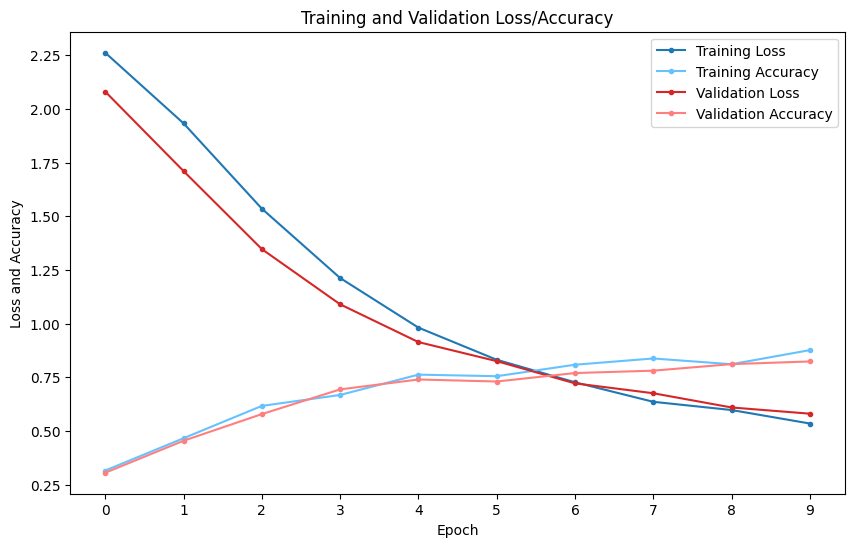


Test Sequence Length: 1000
Testing Standard LSTM:
Segment 01/10 | Loss: 0.5834 | Accuracy: 0.8274
Segment 02/10 | Loss: 0.5786 | Accuracy: 0.8246
Segment 03/10 | Loss: 0.5857 | Accuracy: 0.8265
Segment 04/10 | Loss: 0.5753 | Accuracy: 0.8312
Segment 05/10 | Loss: 0.5743 | Accuracy: 0.8352
Segment 06/10 | Loss: 0.5828 | Accuracy: 0.8288
Segment 07/10 | Loss: 0.5797 | Accuracy: 0.8302
Segment 08/10 | Loss: 0.5846 | Accuracy: 0.8260
Segment 09/10 | Loss: 0.5729 | Accuracy: 0.8309
Segment 10/10 | Loss: 0.5807 | Accuracy: 0.8282

Final Test Loss: 0.5798 | Final Test Accuracy: 0.8289
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2344 | Val Loss: 1.9799 | Training Accuracy: 0.2864 | Val Accuracy: 0.3117
Epoch 02 | Training Loss: 1.8020 | Val Loss: 1.5908 | Training Accuracy: 0.4782 | Val Accuracy: 0.4799
Epoch 03 | Training Loss: 1.4382 | Val Loss: 1.2735 | Training Accuracy: 0

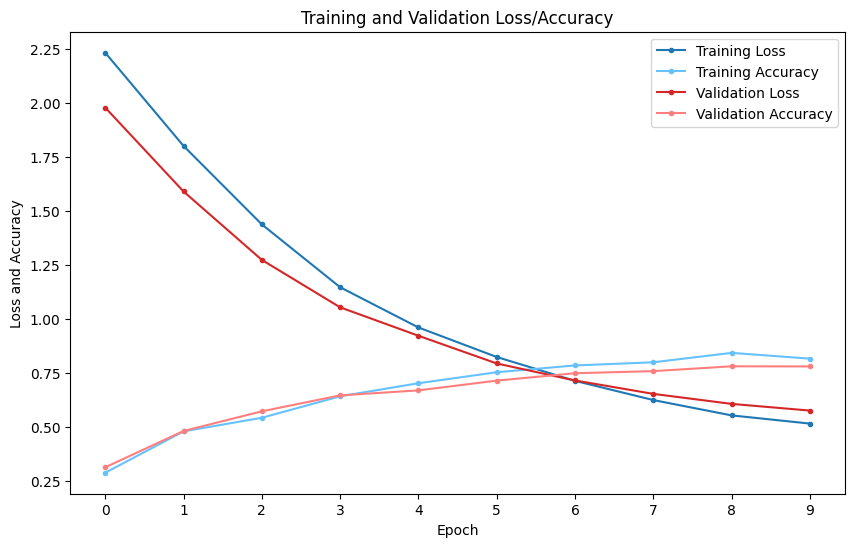


Test Sequence Length: 1000
Testing Multiplicative LSTM:
Segment 01/10 | Loss: 0.5881 | Accuracy: 0.7836
Segment 02/10 | Loss: 0.5881 | Accuracy: 0.7826
Segment 03/10 | Loss: 0.5878 | Accuracy: 0.7787
Segment 04/10 | Loss: 0.5905 | Accuracy: 0.7778
Segment 05/10 | Loss: 0.5912 | Accuracy: 0.7812
Segment 06/10 | Loss: 0.5879 | Accuracy: 0.7785
Segment 07/10 | Loss: 0.5827 | Accuracy: 0.7856
Segment 08/10 | Loss: 0.5774 | Accuracy: 0.7848
Segment 09/10 | Loss: 0.5720 | Accuracy: 0.7922
Segment 10/10 | Loss: 0.5819 | Accuracy: 0.7828

Final Test Loss: 0.5848 | Final Test Accuracy: 0.7828
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2944 | Val Loss: 2.0092 | Training Accuracy: 0.3252 | Val Accuracy: 0.4462
Epoch 02 | Training Loss: 1.8513 | Val Loss: 1.5990 | Training Accuracy: 0.4175 | Val Accuracy: 0.5195
Epoch 03 | Training Loss: 1.4576 | Val Loss: 1.2512 | Training Accuracy: 0.

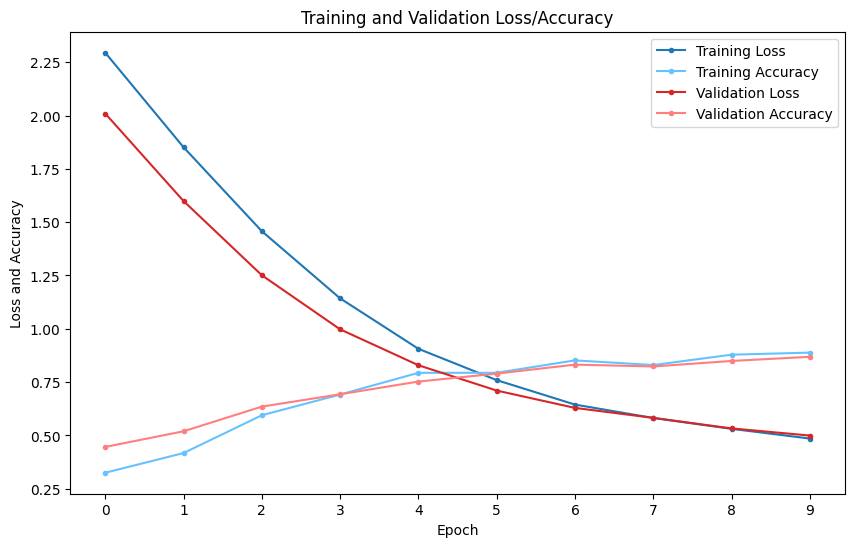


Test Sequence Length: 1000
Testing Standard GRU:
Segment 01/10 | Loss: 0.5216 | Accuracy: 0.8558
Segment 02/10 | Loss: 0.5225 | Accuracy: 0.8522
Segment 03/10 | Loss: 0.5230 | Accuracy: 0.8530
Segment 04/10 | Loss: 0.5195 | Accuracy: 0.8562
Segment 05/10 | Loss: 0.5164 | Accuracy: 0.8618
Segment 06/10 | Loss: 0.5175 | Accuracy: 0.8567
Segment 07/10 | Loss: 0.5170 | Accuracy: 0.8600
Segment 08/10 | Loss: 0.5158 | Accuracy: 0.8603
Segment 09/10 | Loss: 0.5301 | Accuracy: 0.8493
Segment 10/10 | Loss: 0.5232 | Accuracy: 0.8494

Final Test Loss: 0.5206 | Final Test Accuracy: 0.8555
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.4157 | Val Loss: 2.1938 | Training Accuracy: 0.1966 | Val Accuracy: 0.1962
Epoch 02 | Training Loss: 2.0395 | Val Loss: 1.8038 | Training Accuracy: 0.3422 | Val Accuracy: 0.3934
Epoch 03 | Training Loss: 1.6596 | Val Loss: 1.4968 | Training Accuracy: 0.4

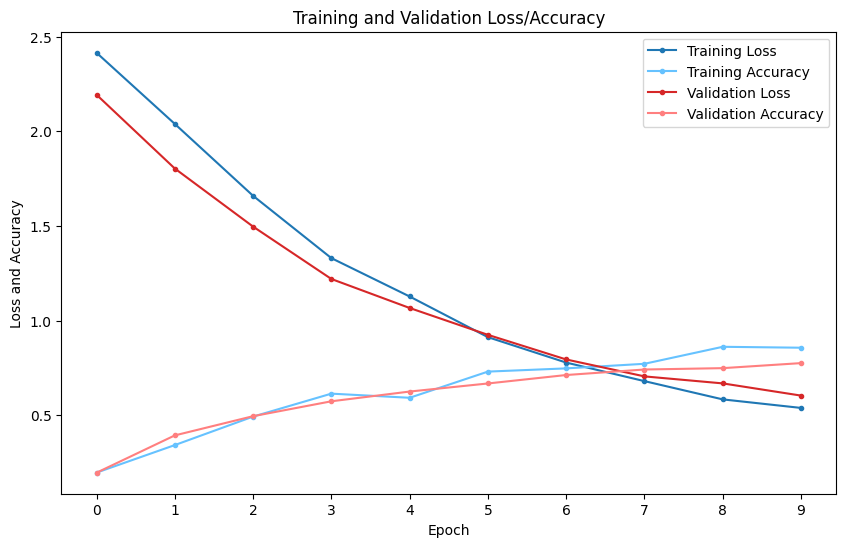


Test Sequence Length: 1000
Testing Multiplicative GRU:
Segment 01/10 | Loss: 0.6119 | Accuracy: 0.7729
Segment 02/10 | Loss: 0.5981 | Accuracy: 0.7770
Segment 03/10 | Loss: 0.6049 | Accuracy: 0.7803
Segment 04/10 | Loss: 0.6000 | Accuracy: 0.7757
Segment 05/10 | Loss: 0.5968 | Accuracy: 0.7817
Segment 06/10 | Loss: 0.5997 | Accuracy: 0.7770
Segment 07/10 | Loss: 0.6098 | Accuracy: 0.7735
Segment 08/10 | Loss: 0.6042 | Accuracy: 0.7698
Segment 09/10 | Loss: 0.6124 | Accuracy: 0.7736
Segment 10/10 | Loss: 0.6060 | Accuracy: 0.7755

Final Test Loss: 0.6044 | Final Test Accuracy: 0.7757
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 2/3 on sequence length of 1000 ***
Standard LSTM
Final Test Loss: 0.5798
Final Test Accuracy: 0.8289

Multiplicative LSTM
Final Test Loss: 0.5848
Final Test Accuracy: 0.7828

Standard GRU
Final Test Loss: 0.5206
Final Test Accuracy: 0.8555

Multiplicative GRU
Final Test

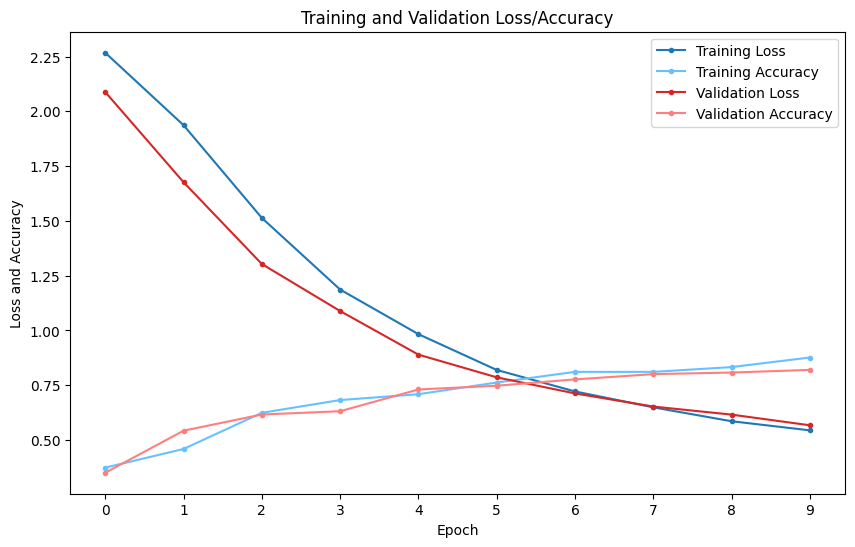


Test Sequence Length: 100
Testing Standard LSTM:

Final Test Loss: 0.5767 | Final Test Accuracy: 0.8143
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.3079 | Val Loss: 2.1639 | Training Accuracy: 0.2597 | Val Accuracy: 0.3193
Epoch 02 | Training Loss: 2.0105 | Val Loss: 1.7828 | Training Accuracy: 0.4369 | Val Accuracy: 0.4304
Epoch 03 | Training Loss: 1.6124 | Val Loss: 1.5001 | Training Accuracy: 0.5461 | Val Accuracy: 0.4947
Epoch 04 | Training Loss: 1.3628 | Val Loss: 1.2653 | Training Accuracy: 0.6141 | Val Accuracy: 0.5787
Epoch 05 | Training Loss: 1.1636 | Val Loss: 1.1052 | Training Accuracy: 0.6553 | Val Accuracy: 0.6262
Epoch 06 | Training Loss: 1.0262 | Val Loss: 1.0020 | Training Accuracy: 0.6723 | Val Accuracy: 0.6426
Epoch 07 | Training Loss: 0.9048 | Val Loss: 0.8598 | Training Accuracy: 0.6990 | Val Accuracy: 0.6933
Epoch 08 | Training Loss: 0.7624 | Val L

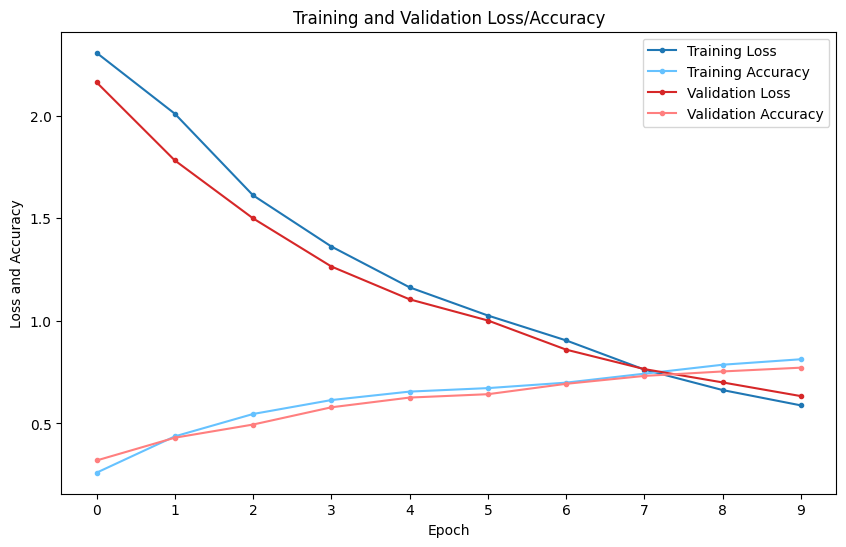


Test Sequence Length: 100
Testing Multiplicative LSTM:

Final Test Loss: 0.6445 | Final Test Accuracy: 0.7678
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3306 | Val Loss: 2.1007 | Training Accuracy: 0.2670 | Val Accuracy: 0.3440
Epoch 02 | Training Loss: 1.9383 | Val Loss: 1.6998 | Training Accuracy: 0.3738 | Val Accuracy: 0.4944
Epoch 03 | Training Loss: 1.5518 | Val Loss: 1.3496 | Training Accuracy: 0.5704 | Val Accuracy: 0.6111
Epoch 04 | Training Loss: 1.2179 | Val Loss: 1.0753 | Training Accuracy: 0.6796 | Val Accuracy: 0.6742
Epoch 05 | Training Loss: 0.9732 | Val Loss: 0.8812 | Training Accuracy: 0.7985 | Val Accuracy: 0.7401
Epoch 06 | Training Loss: 0.8019 | Val Loss: 0.7464 | Training Accuracy: 0.8058 | Val Accuracy: 0.7962
Epoch 07 | Training Loss: 0.6938 | Val Loss: 0.6655 | Training Accuracy: 0.7985 | Val Accuracy: 0.8214
Epoch 08 | Training Loss: 0.6120 | Val Lo

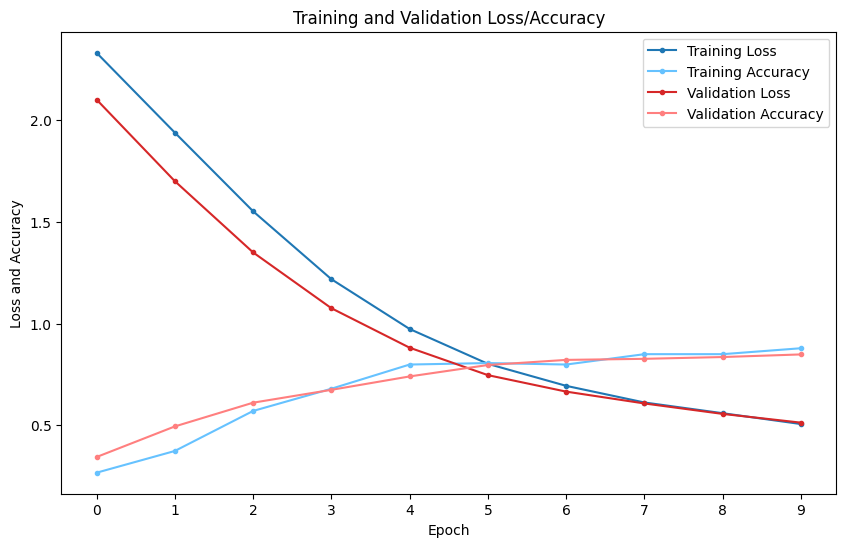


Test Sequence Length: 100
Testing Standard GRU:

Final Test Loss: 0.5397 | Final Test Accuracy: 0.8407
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2757 | Val Loss: 1.9976 | Training Accuracy: 0.2888 | Val Accuracy: 0.3467
Epoch 02 | Training Loss: 1.8408 | Val Loss: 1.6028 | Training Accuracy: 0.4490 | Val Accuracy: 0.4686
Epoch 03 | Training Loss: 1.5053 | Val Loss: 1.4304 | Training Accuracy: 0.4854 | Val Accuracy: 0.5090
Epoch 04 | Training Loss: 1.2509 | Val Loss: 1.1387 | Training Accuracy: 0.6044 | Val Accuracy: 0.6051
Epoch 05 | Training Loss: 1.0286 | Val Loss: 0.9466 | Training Accuracy: 0.6675 | Val Accuracy: 0.6735
Epoch 06 | Training Loss: 0.8499 | Val Loss: 0.8576 | Training Accuracy: 0.7209 | Val Accuracy: 0.6967
Epoch 07 | Training Loss: 0.7462 | Val Loss: 0.7456 | Training Accuracy: 0.7524 | Val Accuracy: 0.7343
Epoch 08 | Training Loss: 0.6566 | Val Los

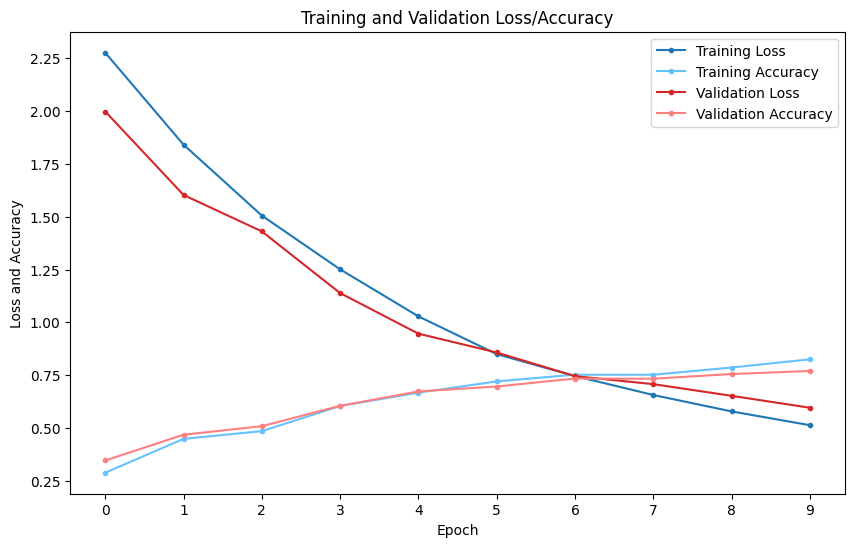


Test Sequence Length: 100
Testing Multiplicative GRU:

Final Test Loss: 0.6254 | Final Test Accuracy: 0.7610
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 100 ***
Standard LSTM
Final Test Loss: 0.5767
Final Test Accuracy: 0.8143

Multiplicative LSTM
Final Test Loss: 0.6445
Final Test Accuracy: 0.7678

Standard GRU
Final Test Loss: 0.5397
Final Test Accuracy: 0.8407

Multiplicative GRU
Final Test Loss: 0.6254
Final Test Accuracy: 0.7610

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2854 | Val Loss: 2.1314 | Training Accuracy: 0.3010 | Val Accuracy: 0.2376
Epoch 02 | Training Loss: 1.9915 | Val Loss: 1.7714 | Training Accuracy: 0.4515 | Val Accuracy: 0.5135
Epoch 03 | Training Loss: 1.6052 | Val Loss: 1.4003 | Training Accuracy: 0.5777 | Val Accuracy: 0.5782
Epoch 04 | Training Loss: 1.2800 | Val Loss: 1.1406 | Training Accuracy: 0.5971 | Val Accuracy: 0.6937
Epo

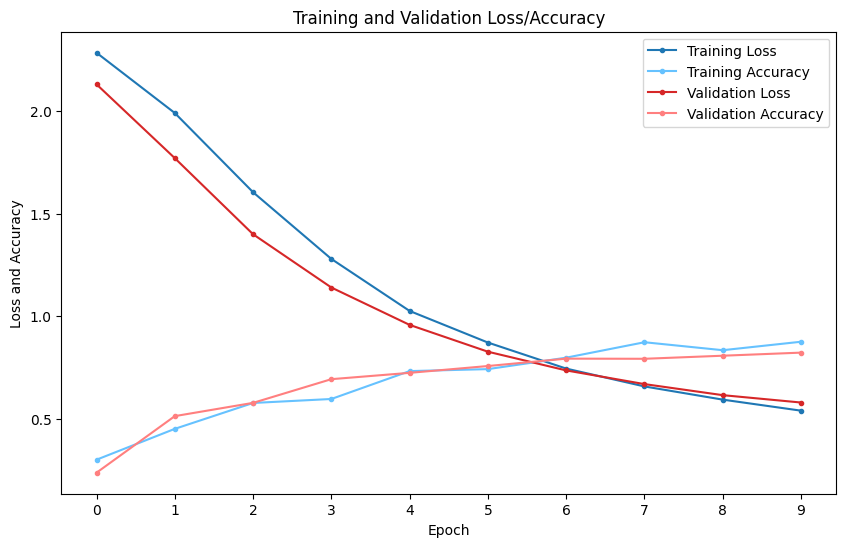


Test Sequence Length: 200
Testing Standard LSTM:
Segment 01/02 | Loss: 0.5800 | Accuracy: 0.8233
Segment 02/02 | Loss: 0.5834 | Accuracy: 0.8186

Final Test Loss: 0.5817 | Final Test Accuracy: 0.8209
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2491 | Val Loss: 2.0192 | Training Accuracy: 0.3762 | Val Accuracy: 0.3150
Epoch 02 | Training Loss: 1.8313 | Val Loss: 1.5821 | Training Accuracy: 0.5680 | Val Accuracy: 0.4838
Epoch 03 | Training Loss: 1.4557 | Val Loss: 1.2816 | Training Accuracy: 0.5631 | Val Accuracy: 0.5738
Epoch 04 | Training Loss: 1.2021 | Val Loss: 1.1081 | Training Accuracy: 0.5801 | Val Accuracy: 0.6258
Epoch 05 | Training Loss: 1.0275 | Val Loss: 1.0087 | Training Accuracy: 0.6699 | Val Accuracy: 0.6502
Epoch 06 | Training Loss: 0.8877 | Val Loss: 0.9014 | Training Accuracy: 0.7573 | Val Accuracy: 0.6950
Epoch 07 | Training Loss: 0.7906 | Val Loss: 0.

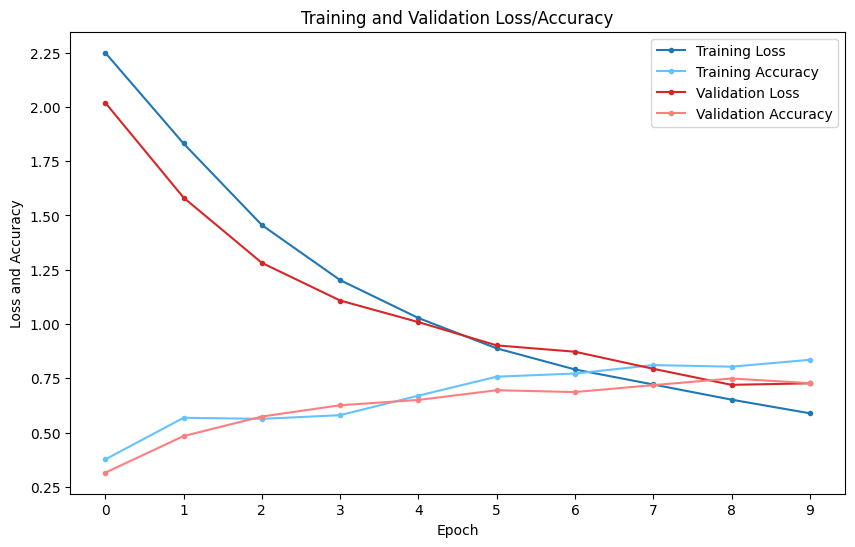


Test Sequence Length: 200
Testing Multiplicative LSTM:
Segment 01/02 | Loss: 0.7426 | Accuracy: 0.7122
Segment 02/02 | Loss: 0.7625 | Accuracy: 0.7090

Final Test Loss: 0.7525 | Final Test Accuracy: 0.7106
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3261 | Val Loss: 2.0253 | Training Accuracy: 0.3544 | Val Accuracy: 0.4578
Epoch 02 | Training Loss: 1.8685 | Val Loss: 1.5946 | Training Accuracy: 0.4903 | Val Accuracy: 0.5641
Epoch 03 | Training Loss: 1.4507 | Val Loss: 1.2513 | Training Accuracy: 0.6432 | Val Accuracy: 0.6423
Epoch 04 | Training Loss: 1.1302 | Val Loss: 1.0007 | Training Accuracy: 0.7136 | Val Accuracy: 0.6763
Epoch 05 | Training Loss: 0.9162 | Val Loss: 0.8408 | Training Accuracy: 0.7573 | Val Accuracy: 0.7730
Epoch 06 | Training Loss: 0.7675 | Val Loss: 0.7140 | Training Accuracy: 0.7718 | Val Accuracy: 0.8011
Epoch 07 | Training Loss: 0.6507 | Val Loss: 0.6

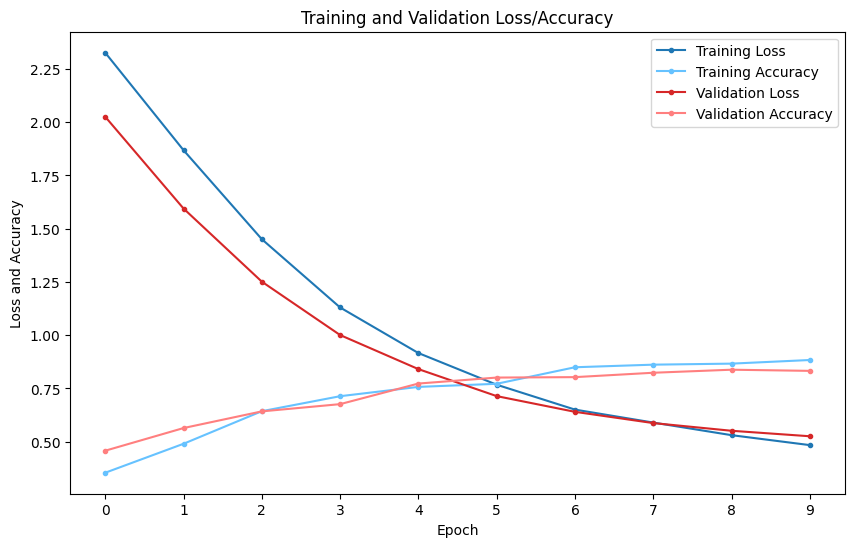


Test Sequence Length: 200
Testing Standard GRU:
Segment 01/02 | Loss: 0.5373 | Accuracy: 0.8257
Segment 02/02 | Loss: 0.5358 | Accuracy: 0.8235

Final Test Loss: 0.5366 | Final Test Accuracy: 0.8246
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2617 | Val Loss: 1.9745 | Training Accuracy: 0.2476 | Val Accuracy: 0.3132
Epoch 02 | Training Loss: 1.8032 | Val Loss: 1.5676 | Training Accuracy: 0.4733 | Val Accuracy: 0.4858
Epoch 03 | Training Loss: 1.4461 | Val Loss: 1.2782 | Training Accuracy: 0.5170 | Val Accuracy: 0.5712
Epoch 04 | Training Loss: 1.1663 | Val Loss: 1.0088 | Training Accuracy: 0.6092 | Val Accuracy: 0.6481
Epoch 05 | Training Loss: 0.9196 | Val Loss: 0.8704 | Training Accuracy: 0.7451 | Val Accuracy: 0.6845
Epoch 06 | Training Loss: 0.7738 | Val Loss: 0.7254 | Training Accuracy: 0.7476 | Val Accuracy: 0.7506
Epoch 07 | Training Loss: 0.6470 | Val Loss: 0.67

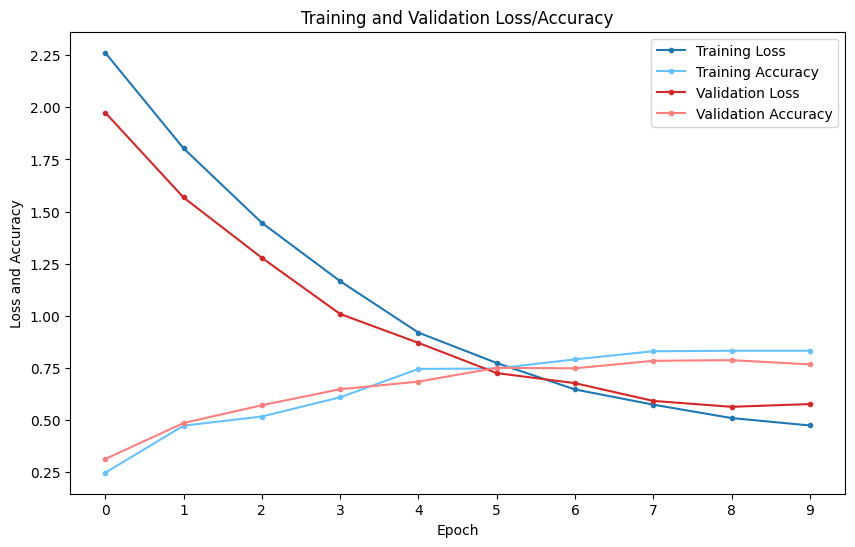


Test Sequence Length: 200
Testing Multiplicative GRU:
Segment 01/02 | Loss: 0.6043 | Accuracy: 0.7640
Segment 02/02 | Loss: 0.5902 | Accuracy: 0.7664

Final Test Loss: 0.5972 | Final Test Accuracy: 0.7652
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 200 ***
Standard LSTM
Final Test Loss: 0.5817
Final Test Accuracy: 0.8209

Multiplicative LSTM
Final Test Loss: 0.7525
Final Test Accuracy: 0.7106

Standard GRU
Final Test Loss: 0.5366
Final Test Accuracy: 0.8246

Multiplicative GRU
Final Test Loss: 0.5972
Final Test Accuracy: 0.7652

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2765 | Val Loss: 2.0948 | Training Accuracy: 0.3471 | Val Accuracy: 0.3667
Epoch 02 | Training Loss: 1.9469 | Val Loss: 1.7281 | Training Accuracy: 0.5607 | Val Accuracy: 0.4921
Epoch 03 | Training Loss: 1.5897 | Val Loss: 1.3883 | Training Accuracy: 0.5850 | Val Accuracy: 0.5786
Epoch 04 |

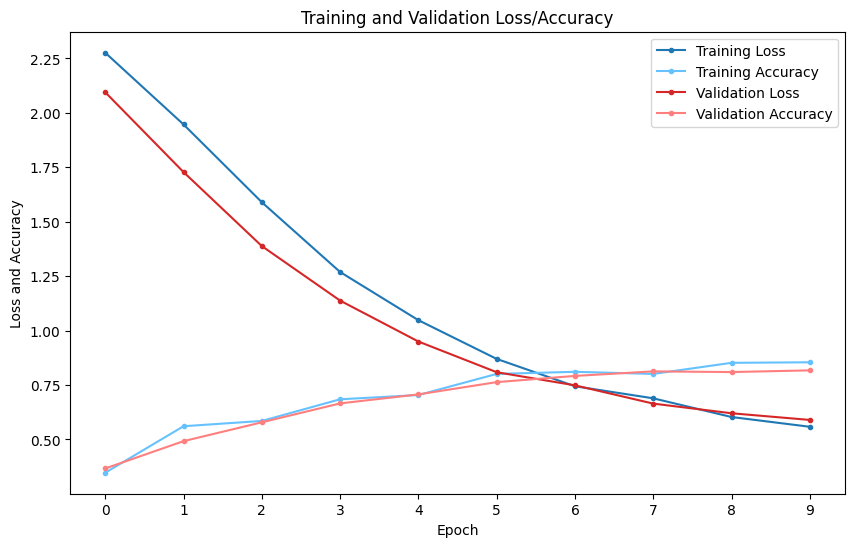


Test Sequence Length: 500
Testing Standard LSTM:
Segment 01/05 | Loss: 0.6077 | Accuracy: 0.8112
Segment 02/05 | Loss: 0.6014 | Accuracy: 0.8103
Segment 03/05 | Loss: 0.5975 | Accuracy: 0.8149
Segment 04/05 | Loss: 0.6038 | Accuracy: 0.8084
Segment 05/05 | Loss: 0.6071 | Accuracy: 0.8076

Final Test Loss: 0.6035 | Final Test Accuracy: 0.8105
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2756 | Val Loss: 2.0780 | Training Accuracy: 0.2427 | Val Accuracy: 0.3576
Epoch 02 | Training Loss: 1.8977 | Val Loss: 1.6024 | Training Accuracy: 0.4782 | Val Accuracy: 0.4884
Epoch 03 | Training Loss: 1.4505 | Val Loss: 1.2692 | Training Accuracy: 0.6141 | Val Accuracy: 0.5931
Epoch 04 | Training Loss: 1.1969 | Val Loss: 1.0844 | Training Accuracy: 0.6141 | Val Accuracy: 0.6546
Epoch 05 | Training Loss: 0.9995 | Val Loss: 0.9221 | Training Accuracy: 0.6869 | Val Accuracy: 0.6953
Epoch 

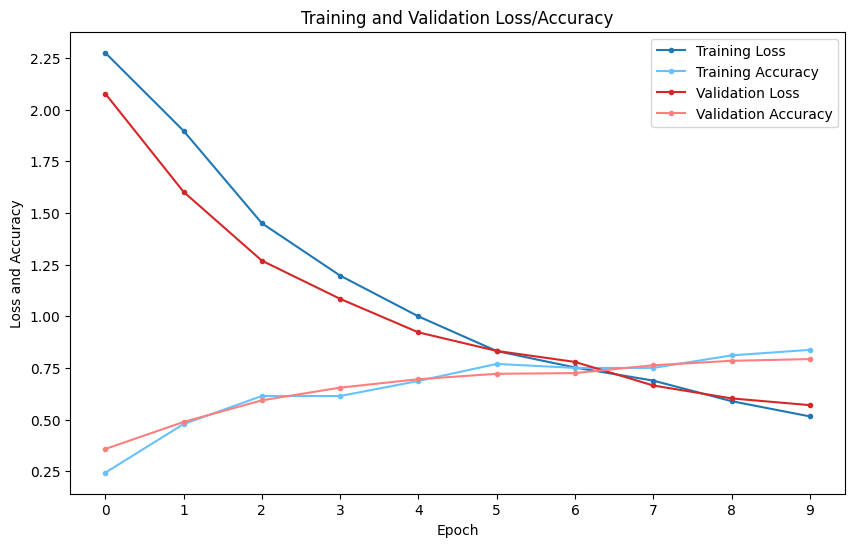


Test Sequence Length: 500
Testing Multiplicative LSTM:
Segment 01/05 | Loss: 0.6040 | Accuracy: 0.7789
Segment 02/05 | Loss: 0.5950 | Accuracy: 0.7838
Segment 03/05 | Loss: 0.5933 | Accuracy: 0.7834
Segment 04/05 | Loss: 0.5898 | Accuracy: 0.7845
Segment 05/05 | Loss: 0.5888 | Accuracy: 0.7828

Final Test Loss: 0.5942 | Final Test Accuracy: 0.7827
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.2977 | Val Loss: 2.0039 | Training Accuracy: 0.3010 | Val Accuracy: 0.3708
Epoch 02 | Training Loss: 1.8543 | Val Loss: 1.6054 | Training Accuracy: 0.4951 | Val Accuracy: 0.5055
Epoch 03 | Training Loss: 1.4657 | Val Loss: 1.2522 | Training Accuracy: 0.5971 | Val Accuracy: 0.6275
Epoch 04 | Training Loss: 1.1533 | Val Loss: 1.0071 | Training Accuracy: 0.6699 | Val Accuracy: 0.6816
Epoch 05 | Training Loss: 0.9255 | Val Loss: 0.8187 | Training Accuracy: 0.7694 | Val Accuracy: 0.7721
Epoch 0

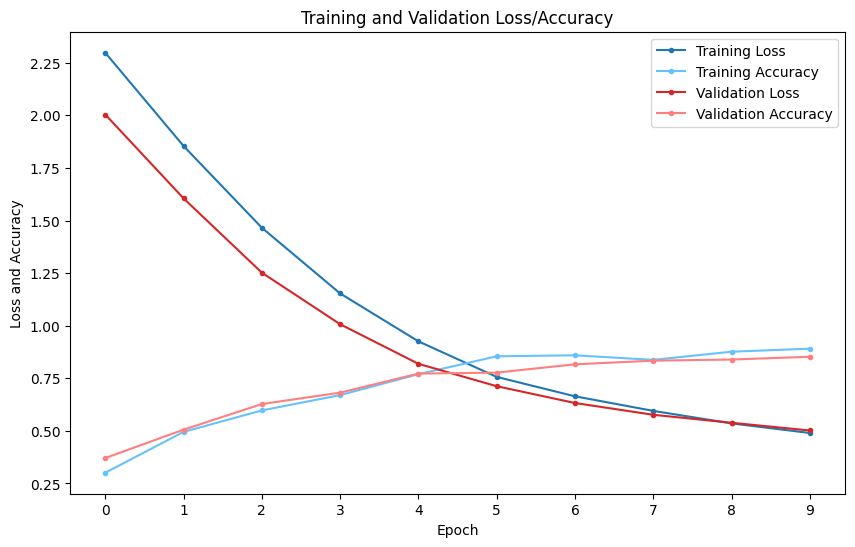


Test Sequence Length: 500
Testing Standard GRU:
Segment 01/05 | Loss: 0.5228 | Accuracy: 0.8471
Segment 02/05 | Loss: 0.5111 | Accuracy: 0.8495
Segment 03/05 | Loss: 0.5175 | Accuracy: 0.8437
Segment 04/05 | Loss: 0.5183 | Accuracy: 0.8460
Segment 05/05 | Loss: 0.5201 | Accuracy: 0.8438

Final Test Loss: 0.5180 | Final Test Accuracy: 0.8460
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.2963 | Val Loss: 2.0604 | Training Accuracy: 0.2621 | Val Accuracy: 0.3013
Epoch 02 | Training Loss: 1.9677 | Val Loss: 1.8184 | Training Accuracy: 0.3714 | Val Accuracy: 0.3869
Epoch 03 | Training Loss: 1.7140 | Val Loss: 1.6136 | Training Accuracy: 0.4248 | Val Accuracy: 0.4343
Epoch 04 | Training Loss: 1.4927 | Val Loss: 1.4263 | Training Accuracy: 0.5704 | Val Accuracy: 0.5106
Epoch 05 | Training Loss: 1.3699 | Val Loss: 1.3337 | Training Accuracy: 0.4903 | Val Accuracy: 0.5283
Epoch 06

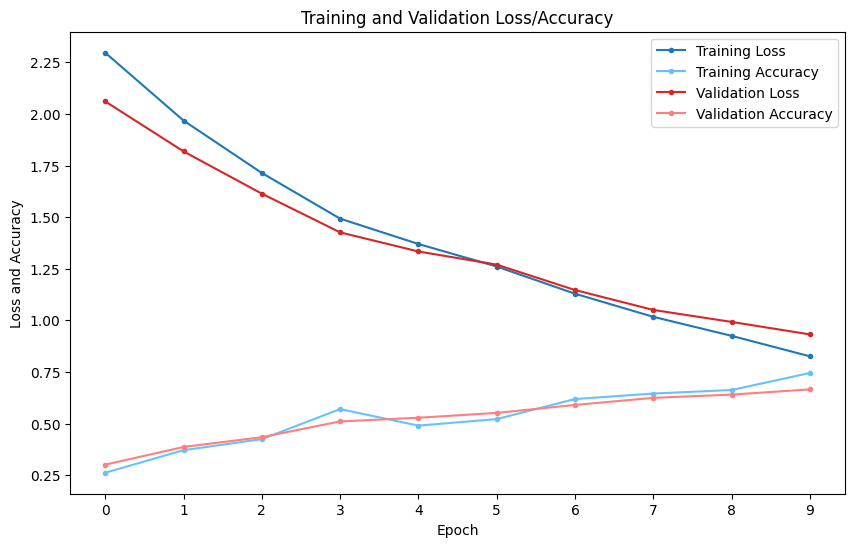


Test Sequence Length: 500
Testing Multiplicative GRU:
Segment 01/05 | Loss: 0.9406 | Accuracy: 0.6634
Segment 02/05 | Loss: 0.9537 | Accuracy: 0.6525
Segment 03/05 | Loss: 0.9625 | Accuracy: 0.6543
Segment 04/05 | Loss: 0.9594 | Accuracy: 0.6513
Segment 05/05 | Loss: 0.9490 | Accuracy: 0.6513

Final Test Loss: 0.9530 | Final Test Accuracy: 0.6546
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 500 ***
Standard LSTM
Final Test Loss: 0.6035
Final Test Accuracy: 0.8105

Multiplicative LSTM
Final Test Loss: 0.5942
Final Test Accuracy: 0.7827

Standard GRU
Final Test Loss: 0.5180
Final Test Accuracy: 0.8460

Multiplicative GRU
Final Test Loss: 0.9530
Final Test Accuracy: 0.6546

Training Standard LSTM:
Epoch 01 | Training Loss: 2.2818 | Val Loss: 2.0780 | Training Accuracy: 0.2330 | Val Accuracy: 0.3301
Epoch 02 | Training Loss: 1.9257 | Val Loss: 1.6663 | Training Accuracy:

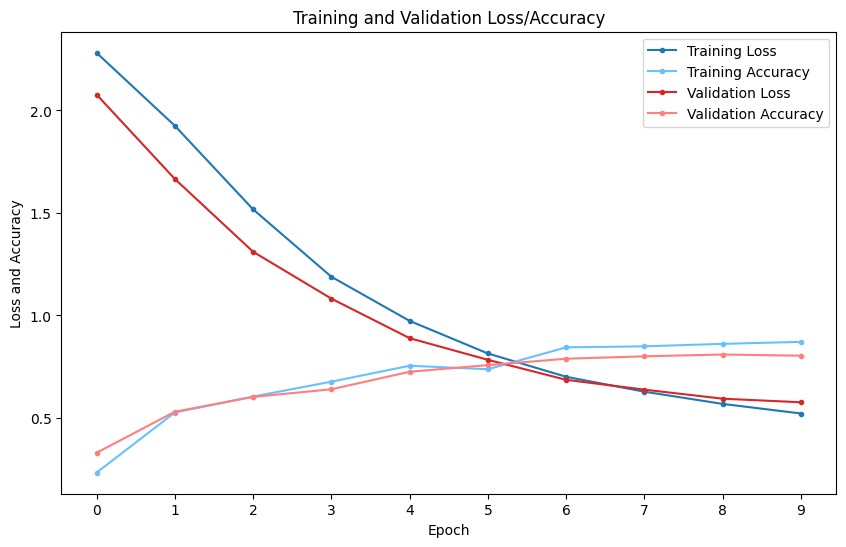


Test Sequence Length: 1000
Testing Standard LSTM:
Segment 01/10 | Loss: 0.5832 | Accuracy: 0.8138
Segment 02/10 | Loss: 0.5716 | Accuracy: 0.8176
Segment 03/10 | Loss: 0.5792 | Accuracy: 0.8067
Segment 04/10 | Loss: 0.5797 | Accuracy: 0.8107
Segment 05/10 | Loss: 0.5841 | Accuracy: 0.8097
Segment 06/10 | Loss: 0.5791 | Accuracy: 0.8094
Segment 07/10 | Loss: 0.5783 | Accuracy: 0.8133
Segment 08/10 | Loss: 0.5731 | Accuracy: 0.8134
Segment 09/10 | Loss: 0.5848 | Accuracy: 0.8069
Segment 10/10 | Loss: 0.5822 | Accuracy: 0.8051

Final Test Loss: 0.5795 | Final Test Accuracy: 0.8107
-------------------------------------------------------------------------------------------------------
Training Multiplicative LSTM:
Epoch 01 | Training Loss: 2.2538 | Val Loss: 2.0387 | Training Accuracy: 0.2476 | Val Accuracy: 0.3244
Epoch 02 | Training Loss: 1.8697 | Val Loss: 1.6381 | Training Accuracy: 0.4369 | Val Accuracy: 0.4622
Epoch 03 | Training Loss: 1.5036 | Val Loss: 1.3569 | Training Accuracy: 0

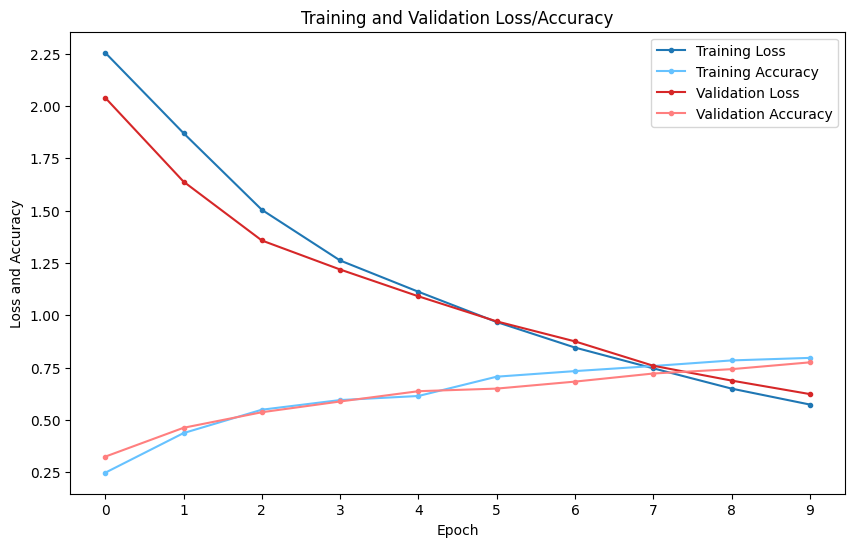


Test Sequence Length: 1000
Testing Multiplicative LSTM:
Segment 01/10 | Loss: 0.6246 | Accuracy: 0.7767
Segment 02/10 | Loss: 0.6306 | Accuracy: 0.7738
Segment 03/10 | Loss: 0.6352 | Accuracy: 0.7702
Segment 04/10 | Loss: 0.6361 | Accuracy: 0.7736
Segment 05/10 | Loss: 0.6398 | Accuracy: 0.7647
Segment 06/10 | Loss: 0.6263 | Accuracy: 0.7769
Segment 07/10 | Loss: 0.6368 | Accuracy: 0.7665
Segment 08/10 | Loss: 0.6233 | Accuracy: 0.7713
Segment 09/10 | Loss: 0.6392 | Accuracy: 0.7712
Segment 10/10 | Loss: 0.6352 | Accuracy: 0.7694

Final Test Loss: 0.6327 | Final Test Accuracy: 0.7714
-------------------------------------------------------------------------------------------------------
Training Standard GRU:
Epoch 01 | Training Loss: 2.3565 | Val Loss: 2.1160 | Training Accuracy: 0.3107 | Val Accuracy: 0.2039
Epoch 02 | Training Loss: 1.9353 | Val Loss: 1.7384 | Training Accuracy: 0.4806 | Val Accuracy: 0.4358
Epoch 03 | Training Loss: 1.5839 | Val Loss: 1.3809 | Training Accuracy: 0.

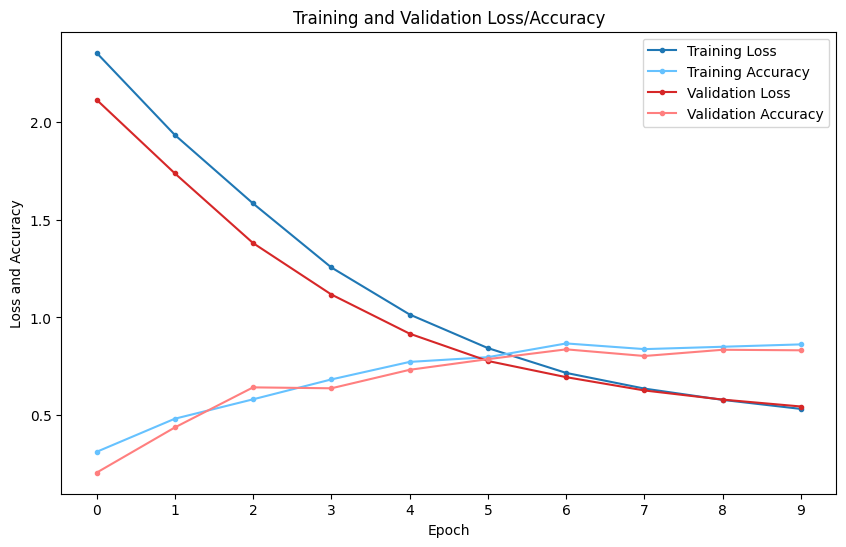


Test Sequence Length: 1000
Testing Standard GRU:
Segment 01/10 | Loss: 0.5452 | Accuracy: 0.8353
Segment 02/10 | Loss: 0.5506 | Accuracy: 0.8334
Segment 03/10 | Loss: 0.5575 | Accuracy: 0.8228
Segment 04/10 | Loss: 0.5653 | Accuracy: 0.8186
Segment 05/10 | Loss: 0.5451 | Accuracy: 0.8312
Segment 06/10 | Loss: 0.5519 | Accuracy: 0.8261
Segment 07/10 | Loss: 0.5555 | Accuracy: 0.8215
Segment 08/10 | Loss: 0.5605 | Accuracy: 0.8180
Segment 09/10 | Loss: 0.5553 | Accuracy: 0.8275
Segment 10/10 | Loss: 0.5528 | Accuracy: 0.8269

Final Test Loss: 0.5540 | Final Test Accuracy: 0.8261
-------------------------------------------------------------------------------------------------------
Training Multiplicative GRU:
Epoch 01 | Training Loss: 2.3010 | Val Loss: 2.0755 | Training Accuracy: 0.2913 | Val Accuracy: 0.3118
Epoch 02 | Training Loss: 1.9362 | Val Loss: 1.7186 | Training Accuracy: 0.4345 | Val Accuracy: 0.4326
Epoch 03 | Training Loss: 1.6108 | Val Loss: 1.4356 | Training Accuracy: 0.4

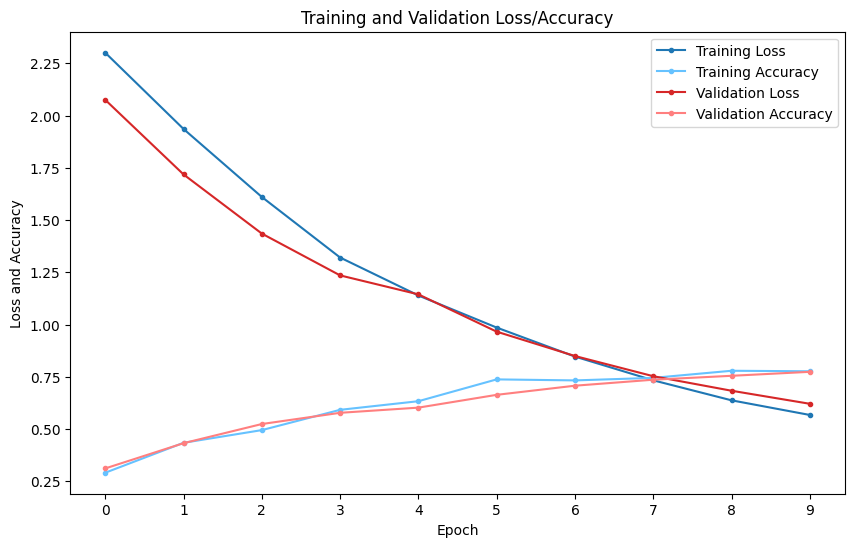


Test Sequence Length: 1000
Testing Multiplicative GRU:
Segment 01/10 | Loss: 0.6458 | Accuracy: 0.7544
Segment 02/10 | Loss: 0.6455 | Accuracy: 0.7586
Segment 03/10 | Loss: 0.6394 | Accuracy: 0.7541
Segment 04/10 | Loss: 0.6521 | Accuracy: 0.7513
Segment 05/10 | Loss: 0.6491 | Accuracy: 0.7552
Segment 06/10 | Loss: 0.6431 | Accuracy: 0.7610
Segment 07/10 | Loss: 0.6619 | Accuracy: 0.7506
Segment 08/10 | Loss: 0.6523 | Accuracy: 0.7561
Segment 09/10 | Loss: 0.6508 | Accuracy: 0.7557
Segment 10/10 | Loss: 0.6420 | Accuracy: 0.7560

Final Test Loss: 0.6482 | Final Test Accuracy: 0.7553
-------------------------------------------------------------------------------------------------------
*** Final metrics report for Trial 3/3 on sequence length of 1000 ***
Standard LSTM
Final Test Loss: 0.5795
Final Test Accuracy: 0.8107

Multiplicative LSTM
Final Test Loss: 0.6327
Final Test Accuracy: 0.7714

Standard GRU
Final Test Loss: 0.5540
Final Test Accuracy: 0.8261

Multiplicative GRU
Final Test

In [20]:
run_benchmark()

# 4. Analyzing Copy Task Results
### Analysis of Results
### Observations on Multiplicative Effects